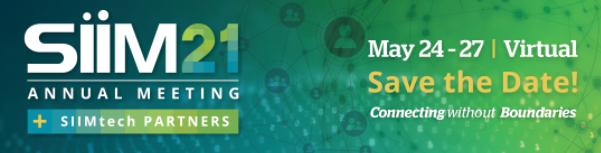

# Simple Regression Model for Bone Age with Pytorch

## SIIM Github Repo

### Task 

Train a deep learning model to estimate the Bone Age from a hand-wrist radiograph. This is an example of a regression model.

### Requirements

1. Basic understanding of machine learning and deep learning
2. Programming in Python

### Learning objectives

At the end of this activity, you will be able to:

1. Understand how to organize your data to use it to train a deep learning model
2. Use a custom data handler in Pytorch to access your dataset to train a model
3. Modify an open source convolutional neural network (EfficientNe B0)
4. Train a model
5. Calculate metrics in the Validation and Test sets


### Acknowledgements

This Jupyter Notebook was based on code by Y. Nakama (https://www.kaggle.com/yasufuminakama) in the SETI Challenge, and by Lucas Pereira (resize pad function), modified by Felipe Kitamura (kitamura.felipe@gmail.com).

The dataset used in this didatic material is from the RSNA Machine Learning Bone Age Challenge (Halabi SS, Prevedello LM, Kalpathy-Cramer J, The RSNA Pediatric Bone Age Machine Learning Challenge. 2018. Radiology. doi: https://doi.org/10.1148/radiol.2018180736).


# Installing and Loading Libraries

In [ ]:
!pip install albumentations==0.4.6
!pip install timm
!pip3 -q install gdown==4.2.0
!curl https://raw.githubusercontent.com/kitamura-felipe/machine-learning/master/Education/Regression-Boneage/preprocess.py > preprocess.py
!curl https://raw.githubusercontent.com/kitamura-felipe/machine-learning/master/Education/Regression-Boneage/boneage-training-dataset.csv > boneage-training-dataset.csv

     |████████████████████████████████| 117 kB 14.7 MB/s 
     |████████████████████████████████| 948 kB 54.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=2db1f7e378560e503b27b7df1b1c1423f24119ce7c8af0209433857e0d52553c
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 376 kB 15.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  % Total    % Received % Xferd  Average Speed   Time 

In [ ]:
# ====================================================
# Library
# ====================================================

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_absolute_error

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns

from preprocess import resize_pad, preprocess


VER = '003SIIM'
GPU = '0'
pixels = 224

device = torch.device('cuda:' + GPU if torch.cuda.is_available() else 'cpu')

# Data Loading

In this step we load the CSV file containing the bone age and the gender for each image in our dataset. The bone age is in months.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1KwBrNxlC8MmEV6MIg44mPZEBUtOc96et/view?usp=sharing
!mkdir boneage-training-dataset-224x224/
!unzip -qq boneage-training-dataset-224x224

Downloading...
From: https://drive.google.com/uc?id=1KwBrNxlC8MmEV6MIg44mPZEBUtOc96et
To: /content/boneage-training-dataset-224x224.zip
100% 648M/648M [00:06<00:00, 93.9MB/s]


In [ ]:
train = pd.read_csv('boneage-training-dataset.csv')


def get_train_file_path(image_id):
    return "boneage-training-dataset-224x224/{}.png".format(image_id)


train['file_path'] = train['id'].apply(get_train_file_path)


display(train.head())


,id,boneage,male,file_path
0,1377,180,False,boneage-training-dataset-224x224/1377.png
1,1378,12,False,boneage-training-dataset-224x224/1378.png
2,1379,94,False,boneage-training-dataset-224x224/1379.png
3,1380,120,True,boneage-training-dataset-224x224/1380.png
4,1381,82,False,boneage-training-dataset-224x224/1381.png


# Quick EDA

Let's print some images and their corresponding bone ages so we can have a sense of what our dataset looks like.

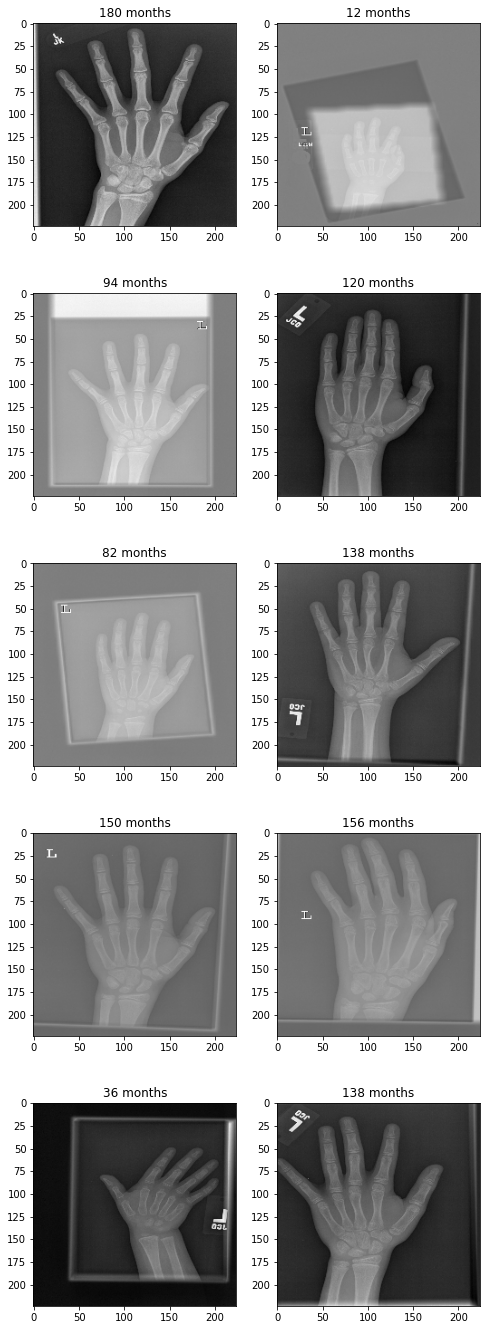

In [ ]:
plt.figure(figsize=(8, 24))
for i in range(10):
    image = cv2.imread(train.loc[i, 'file_path']) # (6, 273, 256)
    #image = image.astype(np.float32)
    image = image / 255.
    image2 = np.zeros((pixels,pixels,3))
    for j in range(image.shape[2]):
        image2[..., j] = resize_pad(image[...,j], pixels)
    plt.subplot(5, 2, i + 1)
    plt.title(str(train.loc[i, 'boneage']) + ' months')
    plt.imshow(image2)
plt.show()

To find out the number of cases for each age, we plot a histogram.

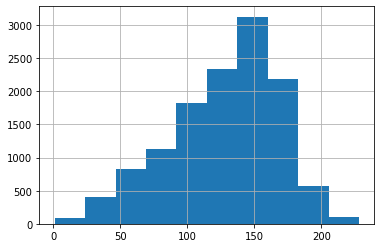

In [ ]:
train['boneage'].hist();

# Directory settings

Here we create the folder where we will save the models we will train.

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = 'model/' + VER + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

We need to specify which model we will use, input and output format, training hyperparameters. We do that by defining a simple class named CFG with all the properties below.

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=50
    num_workers=28
    model_name='efficientnet_b0' #'nfnet_l0'
    size_x=pixels
    size_y=pixels
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=6
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=3e-4
    min_lr=3e-7
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='boneage'
    n_fold=10
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8]
    tst_fold = 9
    train=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Utils

get_score is a function to determine de mean absolute error of our model

init_logger logs the training information (metrics) in a log file

seed_torch sets the seed of random number generators to improve reproducibility.

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    #score = np.mean(np.abs(y_true - y_pred)) * 200.
    score = mean_absolute_error(y_true, y_pred) * 200.
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Cross Validation split

We will now split the bone age dataset into 10 folds (0, 1, 2, ..., 9).

Fold 9 will be our hold out test set, so it wil not be included in the cross-validation.

Folds 0 to 8 will be used to train with the cross-validation policy:

1. Use fold 0 as validation set and the rest of the folds as training set
2. Use fold 1 as validation set and the rest of the folds as training set
3. Use fold 2 as validation set and the rest of the folds as training set

And so forth.

Each of these folds will be used to train a model. We will end up with 9 models that we well use to do inference in the test set (fold 9).

In [ ]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'boneage', 'male']).size())

fold  boneage  male 
0     10       True      1
      12       True      1
      15       False     1
      18       False     2
      20       True      1
                        ..
9     204      False     3
               True     17
      210      True      1
      216      True      7
      228      True      1
Length: 1143, dtype: int64

# Dataset

This is where we define de datahandlers for the training set and for the validation set.

The data handlers are the classes responsible for loading the images, preprocessing them, doing the data augmentation (if we need to), and loading the corresponding label (bone age) to feed our model during training.

In our case, the training and validation data handlers are exactly the same, but in some cases we may want to load the validation dataset diferently.

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.gender = df['male'].values * 1.
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = image.astype(np.float32) / 255.

        image2 = np.zeros((CFG.size_x, CFG.size_y,3))
        
        for j in range(image.shape[2]):
            image2[..., j] = resize_pad(image[...,j], CFG.size_x)
        
        image = image2.astype(np.float32)
        
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        image[:16, :16, ...] = self.gender[idx]
        
        label = torch.tensor(self.labels[idx]).float() / 200.
        
        return image, label
    
class ValidDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.gender = df['male'].values * 1.
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = image.astype(np.float32) / 255.
        
        image2 = np.zeros((CFG.size_x, CFG.size_y,3))
        
        for j in range(image.shape[2]):
            image2[..., j] = resize_pad(image[...,j], CFG.size_x)
        
        image = image2.astype(np.float32)
        
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        image[:16, :16, ...] = self.gender[idx]
        
        label = torch.tensor(self.labels[idx]).float() / 200.
        return image, label

# Transforms

Our data handlers use this get_transform function to make transformations to our data. Notice we always resize the images in both train and valid. However, we only apply data augmentation to the training set (shift, scale, rotate, brightness, and contrast)

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Resize(CFG.size_x, CFG.size_y),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size_x, CFG.size_y),
            ToTensorV2(),
        ])


# Model Architecture

Our custom model is based on a pretrained model loaded from TIMM and modified to have a regression head, which is a dense layer with a single neuron and no activation function. In our case, the pretrained model is an EfficientNetB0 (defined in the configuration step above).

In [ ]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)

    def forward(self, x):
        output = self.model(x)
        return output

# Helper functions

Here we define functions to help us keep track of the metrics, their averages, and time.

We also define a function to train our models and another one to measure how well we do in the validation set.

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

This part of the code defines the train loop, which is:

1. Load the correct folds for training and validation for each fold in our cross-validation policy.
2. Train the model
3. Save the model at the end of each epoch, if it is the best model in the validation set so far.
4. Print metrics
5. Go to the next fold

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[(folds['fold'] != fold) & (folds['fold'] != CFG.tst_fold)].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values / 200.

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = ValidDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.L1Loss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values / 200.
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()

        for fold in CFG.trn_fold:
            _oof_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

This is when the training takes place...

Go grab a coffe as it may take 10 min per fold (90 min) to train all the 9 folds.

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


Epoch: [1][0/630] Data 4.402 (4.402) Elapsed 0m 5s (remain 55m 10s) Loss: 0.6995(0.6995) Grad: 6.0912  
Epoch: [1][50/630] Data 0.000 (0.087) Elapsed 0m 12s (remain 2m 16s) Loss: 0.1077(0.2105) Grad: 3.5818  
Epoch: [1][100/630] Data 0.000 (0.044) Elapsed 0m 18s (remain 1m 38s) Loss: 0.1650(0.1789) Grad: 2.3137  
Epoch: [1][150/630] Data 0.000 (0.029) Elapsed 0m 25s (remain 1m 21s) Loss: 0.1357(0.1614) Grad: 2.2848  
Epoch: [1][200/630] Data 0.000 (0.022) Elapsed 0m 32s (remain 1m 9s) Loss: 0.1281(0.1477) Grad: 3.1020  
Epoch: [1][250/630] Data 0.000 (0.018) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0497(0.1381) Grad: 1.9356  
Epoch: [1][300/630] Data 0.000 (0.015) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0644(0.1304) Grad: 1.4747  
Epoch: [1][350/630] Data 0.000 (0.013) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0814(0.1249) Grad: 2.7870  
Epoch: [1][400/630] Data 0.000 (0.011) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0801(0.1195) Grad: 1.9824  
Epoch: [1][450/630] Data 0.000 (0.010) Elapsed 1m 6s

Epoch 1 - avg_train_loss: 0.1043  avg_val_loss: 0.0586  time: 97s
Epoch 1 - Score: 11.7255
Epoch 1 - Save Best Score: 11.7255 Model
Epoch 1 - Save Best Loss: 0.0586 Model


Epoch: [2][0/630] Data 2.287 (2.287) Elapsed 0m 4s (remain 49m 0s) Loss: 0.0533(0.0533) Grad: 1.0535  
Epoch: [2][50/630] Data 0.000 (0.045) Elapsed 0m 11s (remain 2m 13s) Loss: 0.1041(0.0672) Grad: 1.5912  
Epoch: [2][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0675(0.0659) Grad: 4.0818  
Epoch: [2][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 22s) Loss: 0.0665(0.0650) Grad: 1.8927  
Epoch: [2][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 10s) Loss: 0.0631(0.0647) Grad: 1.0208  
Epoch: [2][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0840(0.0639) Grad: 2.8217  
Epoch: [2][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 51s) Loss: 0.0589(0.0643) Grad: 1.7246  
Epoch: [2][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0966(0.0635) Grad: 3.4657  
Epoch: [2][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0598(0.0628) Grad: 3.0443  
Epoch: [2][450/630] Data 0.000 (0.005) Elapsed 1m 6s

Epoch 2 - avg_train_loss: 0.0622  avg_val_loss: 0.0624  time: 97s
Epoch 2 - Score: 12.4776


Epoch: [3][0/630] Data 1.615 (1.615) Elapsed 0m 4s (remain 47m 9s) Loss: 0.0536(0.0536) Grad: 0.8630  
Epoch: [3][50/630] Data 0.000 (0.032) Elapsed 0m 11s (remain 2m 11s) Loss: 0.0547(0.0561) Grad: 2.3766  
Epoch: [3][100/630] Data 0.000 (0.016) Elapsed 0m 18s (remain 1m 36s) Loss: 0.0674(0.0566) Grad: 0.9193  
Epoch: [3][150/630] Data 0.000 (0.011) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0572(0.0553) Grad: 2.2807  
Epoch: [3][200/630] Data 0.000 (0.008) Elapsed 0m 31s (remain 1m 8s) Loss: 0.0496(0.0557) Grad: 3.9646  
Epoch: [3][250/630] Data 0.000 (0.007) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0423(0.0557) Grad: 0.9760  
Epoch: [3][300/630] Data 0.000 (0.006) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0536(0.0548) Grad: 1.1867  
Epoch: [3][350/630] Data 0.000 (0.005) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0579(0.0548) Grad: 1.8239  
Epoch: [3][400/630] Data 0.000 (0.004) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0693(0.0548) Grad: 1.6007  
Epoch: [3][450/630] Data 0.000 (0.004) Elapsed 1m 5

Epoch 3 - avg_train_loss: 0.0533  avg_val_loss: 0.0457  time: 96s
Epoch 3 - Score: 9.1389
Epoch 3 - Save Best Score: 9.1389 Model
Epoch 3 - Save Best Loss: 0.0457 Model


Epoch: [4][0/630] Data 3.294 (3.294) Elapsed 0m 4s (remain 48m 39s) Loss: 0.0366(0.0366) Grad: 0.5729  
Epoch: [4][50/630] Data 0.000 (0.065) Elapsed 0m 11s (remain 2m 11s) Loss: 0.0513(0.0479) Grad: 1.3535  
Epoch: [4][100/630] Data 0.000 (0.033) Elapsed 0m 18s (remain 1m 36s) Loss: 0.0469(0.0470) Grad: 0.8324  
Epoch: [4][150/630] Data 0.000 (0.022) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0485(0.0468) Grad: 1.9697  
Epoch: [4][200/630] Data 0.000 (0.017) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0364(0.0466) Grad: 1.5798  
Epoch: [4][250/630] Data 0.000 (0.013) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0425(0.0464) Grad: 1.1337  
Epoch: [4][300/630] Data 0.000 (0.011) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0394(0.0467) Grad: 0.9441  
Epoch: [4][350/630] Data 0.000 (0.010) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0316(0.0468) Grad: 1.3536  
Epoch: [4][400/630] Data 0.000 (0.008) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0405(0.0466) Grad: 0.9971  
Epoch: [4][450/630] Data 0.000 (0.008) Elapsed 1m 6

Epoch 4 - avg_train_loss: 0.0467  avg_val_loss: 0.0437  time: 98s
Epoch 4 - Score: 8.7317
Epoch 4 - Save Best Score: 8.7317 Model
Epoch 4 - Save Best Loss: 0.0437 Model


Epoch: [5][0/630] Data 1.778 (1.778) Elapsed 0m 4s (remain 48m 43s) Loss: 0.0433(0.0433) Grad: 1.2398  
Epoch: [5][50/630] Data 0.000 (0.035) Elapsed 0m 11s (remain 2m 10s) Loss: 0.0391(0.0434) Grad: 2.3157  
Epoch: [5][100/630] Data 0.000 (0.018) Elapsed 0m 18s (remain 1m 35s) Loss: 0.0343(0.0428) Grad: 1.8342  
Epoch: [5][150/630] Data 0.000 (0.012) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0336(0.0424) Grad: 0.6616  
Epoch: [5][200/630] Data 0.000 (0.009) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0332(0.0428) Grad: 1.4158  
Epoch: [5][250/630] Data 0.000 (0.007) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0389(0.0427) Grad: 1.6059  
Epoch: [5][300/630] Data 0.000 (0.006) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0414(0.0429) Grad: 0.7775  
Epoch: [5][350/630] Data 0.000 (0.005) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0720(0.0428) Grad: 1.6196  
Epoch: [5][400/630] Data 0.000 (0.005) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0405(0.0426) Grad: 0.7816  
Epoch: [5][450/630] Data 0.000 (0.004) Elapsed 1m 

Epoch 5 - avg_train_loss: 0.0425  avg_val_loss: 0.0419  time: 96s
Epoch 5 - Score: 8.3736
Epoch 5 - Save Best Score: 8.3736 Model
Epoch 5 - Save Best Loss: 0.0419 Model


Epoch: [6][0/630] Data 2.886 (2.886) Elapsed 0m 4s (remain 49m 11s) Loss: 0.0412(0.0412) Grad: 1.7651  
Epoch: [6][50/630] Data 0.000 (0.057) Elapsed 0m 11s (remain 2m 12s) Loss: 0.0426(0.0376) Grad: 0.6889  
Epoch: [6][100/630] Data 0.000 (0.029) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0484(0.0383) Grad: 0.7841  
Epoch: [6][150/630] Data 0.000 (0.019) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0479(0.0384) Grad: 1.4129  
Epoch: [6][200/630] Data 0.000 (0.015) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0400(0.0390) Grad: 0.8115  
Epoch: [6][250/630] Data 0.000 (0.012) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0428(0.0391) Grad: 2.5019  
Epoch: [6][300/630] Data 0.000 (0.010) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0543(0.0389) Grad: 1.6582  
Epoch: [6][350/630] Data 0.000 (0.008) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0336(0.0389) Grad: 1.7946  
Epoch: [6][400/630] Data 0.000 (0.007) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0473(0.0393) Grad: 0.7609  
Epoch: [6][450/630] Data 0.000 (0.007) Elapsed 1m 7

Epoch 6 - avg_train_loss: 0.0393  avg_val_loss: 0.0393  time: 98s
Epoch 6 - Score: 7.8501
Epoch 6 - Save Best Score: 7.8501 Model
Epoch 6 - Save Best Loss: 0.0393 Model
========== fold: 0 result ==========
Score: 7.8501
========== fold: 1 training ==========


Epoch: [1][0/630] Data 2.823 (2.823) Elapsed 0m 4s (remain 48m 55s) Loss: 0.5813(0.5813) Grad: 6.0666  
Epoch: [1][50/630] Data 0.000 (0.056) Elapsed 0m 11s (remain 2m 13s) Loss: 0.2499(0.2159) Grad: 3.8835  
Epoch: [1][100/630] Data 0.000 (0.028) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0906(0.1817) Grad: 2.8967  
Epoch: [1][150/630] Data 0.000 (0.019) Elapsed 0m 25s (remain 1m 21s) Loss: 0.1113(0.1649) Grad: 2.6160  
Epoch: [1][200/630] Data 0.000 (0.014) Elapsed 0m 32s (remain 1m 9s) Loss: 0.1701(0.1528) Grad: 2.8738  
Epoch: [1][250/630] Data 0.000 (0.012) Elapsed 0m 39s (remain 0m 59s) Loss: 0.1189(0.1421) Grad: 1.7420  
Epoch: [1][300/630] Data 0.000 (0.010) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0926(0.1341) Grad: 3.2137  
Epoch: [1][350/630] Data 0.000 (0.008) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0863(0.1283) Grad: 2.8182  
Epoch: [1][400/630] Data 0.000 (0.007) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0565(0.1221) Grad: 1.4460  
Epoch: [1][450/630] Data 0.000 (0.007) Elapsed 1m 7

Epoch 1 - avg_train_loss: 0.1042  avg_val_loss: 0.0557  time: 98s
Epoch 1 - Score: 11.1418
Epoch 1 - Save Best Score: 11.1418 Model
Epoch 1 - Save Best Loss: 0.0557 Model


Epoch: [2][0/630] Data 2.107 (2.107) Elapsed 0m 4s (remain 48m 47s) Loss: 0.0734(0.0734) Grad: 1.4205  
Epoch: [2][50/630] Data 0.000 (0.042) Elapsed 0m 11s (remain 2m 12s) Loss: 0.0856(0.0680) Grad: 3.7155  
Epoch: [2][100/630] Data 0.000 (0.021) Elapsed 0m 18s (remain 1m 36s) Loss: 0.0891(0.0674) Grad: 1.3795  
Epoch: [2][150/630] Data 0.000 (0.014) Elapsed 0m 25s (remain 1m 19s) Loss: 0.0706(0.0699) Grad: 3.4267  
Epoch: [2][200/630] Data 0.000 (0.011) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0678(0.0688) Grad: 1.0381  
Epoch: [2][250/630] Data 0.000 (0.009) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0429(0.0670) Grad: 1.1651  
Epoch: [2][300/630] Data 0.000 (0.007) Elapsed 0m 45s (remain 0m 50s) Loss: 0.0417(0.0668) Grad: 1.5485  
Epoch: [2][350/630] Data 0.000 (0.006) Elapsed 0m 52s (remain 0m 42s) Loss: 0.0828(0.0663) Grad: 3.0738  
Epoch: [2][400/630] Data 0.000 (0.005) Elapsed 0m 59s (remain 0m 34s) Loss: 0.0615(0.0657) Grad: 1.3589  
Epoch: [2][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 2 - avg_train_loss: 0.0634  avg_val_loss: 0.0520  time: 97s
Epoch 2 - Score: 10.3944
Epoch 2 - Save Best Score: 10.3944 Model
Epoch 2 - Save Best Loss: 0.0520 Model


Epoch: [3][0/630] Data 2.233 (2.233) Elapsed 0m 4s (remain 49m 25s) Loss: 0.0583(0.0583) Grad: 1.1396  
Epoch: [3][50/630] Data 0.000 (0.044) Elapsed 0m 11s (remain 2m 13s) Loss: 0.0670(0.0550) Grad: 0.9469  
Epoch: [3][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0874(0.0549) Grad: 3.4405  
Epoch: [3][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0386(0.0569) Grad: 2.7995  
Epoch: [3][200/630] Data 0.000 (0.011) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0943(0.0564) Grad: 1.6037  
Epoch: [3][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0568(0.0557) Grad: 1.3315  
Epoch: [3][300/630] Data 0.000 (0.008) Elapsed 0m 45s (remain 0m 50s) Loss: 0.0564(0.0553) Grad: 1.3242  
Epoch: [3][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0606(0.0543) Grad: 1.6262  
Epoch: [3][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0551(0.0545) Grad: 3.1560  
Epoch: [3][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 3 - avg_train_loss: 0.0535  avg_val_loss: 0.0505  time: 96s
Epoch 3 - Score: 10.0986
Epoch 3 - Save Best Score: 10.0986 Model
Epoch 3 - Save Best Loss: 0.0505 Model


Epoch: [4][0/630] Data 1.640 (1.640) Elapsed 0m 4s (remain 47m 32s) Loss: 0.0540(0.0540) Grad: 2.6773  
Epoch: [4][50/630] Data 0.000 (0.033) Elapsed 0m 11s (remain 2m 10s) Loss: 0.0435(0.0486) Grad: 1.2128  
Epoch: [4][100/630] Data 0.000 (0.017) Elapsed 0m 18s (remain 1m 35s) Loss: 0.0330(0.0490) Grad: 1.2962  
Epoch: [4][150/630] Data 0.000 (0.011) Elapsed 0m 25s (remain 1m 19s) Loss: 0.0393(0.0473) Grad: 2.8582  
Epoch: [4][200/630] Data 0.000 (0.008) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0481(0.0469) Grad: 2.3646  
Epoch: [4][250/630] Data 0.000 (0.007) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0461(0.0471) Grad: 1.0054  
Epoch: [4][300/630] Data 0.000 (0.006) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0436(0.0467) Grad: 0.8642  
Epoch: [4][350/630] Data 0.000 (0.005) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0488(0.0467) Grad: 2.2176  
Epoch: [4][400/630] Data 0.000 (0.004) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0507(0.0469) Grad: 0.9421  
Epoch: [4][450/630] Data 0.000 (0.004) Elapsed 1m 

Epoch 4 - avg_train_loss: 0.0469  avg_val_loss: 0.0480  time: 96s
Epoch 4 - Score: 9.6000
Epoch 4 - Save Best Score: 9.6000 Model
Epoch 4 - Save Best Loss: 0.0480 Model


Epoch: [5][0/630] Data 1.991 (1.991) Elapsed 0m 4s (remain 47m 8s) Loss: 0.0582(0.0582) Grad: 2.3849  
Epoch: [5][50/630] Data 0.000 (0.039) Elapsed 0m 11s (remain 2m 8s) Loss: 0.0345(0.0426) Grad: 1.0600  
Epoch: [5][100/630] Data 0.000 (0.020) Elapsed 0m 18s (remain 1m 34s) Loss: 0.0371(0.0431) Grad: 1.2653  
Epoch: [5][150/630] Data 0.000 (0.013) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0413(0.0430) Grad: 3.6680  
Epoch: [5][200/630] Data 0.000 (0.010) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0388(0.0428) Grad: 2.4775  
Epoch: [5][250/630] Data 0.000 (0.008) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0497(0.0435) Grad: 0.8644  
Epoch: [5][300/630] Data 0.000 (0.007) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0417(0.0435) Grad: 2.1123  
Epoch: [5][350/630] Data 0.000 (0.006) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0499(0.0433) Grad: 2.1282  
Epoch: [5][400/630] Data 0.000 (0.005) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0470(0.0434) Grad: 0.6424  
Epoch: [5][450/630] Data 0.000 (0.005) Elapsed 1m 5s

Epoch 5 - avg_train_loss: 0.0428  avg_val_loss: 0.0410  time: 96s
Epoch 5 - Score: 8.2058
Epoch 5 - Save Best Score: 8.2058 Model
Epoch 5 - Save Best Loss: 0.0410 Model


Epoch: [6][0/630] Data 2.225 (2.225) Elapsed 0m 4s (remain 49m 17s) Loss: 0.0208(0.0208) Grad: 0.8831  
Epoch: [6][50/630] Data 0.000 (0.044) Elapsed 0m 11s (remain 2m 11s) Loss: 0.0303(0.0375) Grad: 0.8681  
Epoch: [6][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 36s) Loss: 0.0331(0.0393) Grad: 1.0268  
Epoch: [6][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 19s) Loss: 0.0399(0.0388) Grad: 0.8181  
Epoch: [6][200/630] Data 0.000 (0.011) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0260(0.0388) Grad: 0.6117  
Epoch: [6][250/630] Data 0.000 (0.009) Elapsed 0m 38s (remain 0m 57s) Loss: 0.0461(0.0390) Grad: 1.2369  
Epoch: [6][300/630] Data 0.000 (0.008) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0402(0.0391) Grad: 0.8514  
Epoch: [6][350/630] Data 0.000 (0.007) Elapsed 0m 51s (remain 0m 41s) Loss: 0.0400(0.0392) Grad: 1.3575  
Epoch: [6][400/630] Data 0.000 (0.006) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0445(0.0390) Grad: 0.8890  
Epoch: [6][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 6 - avg_train_loss: 0.0389  avg_val_loss: 0.0403  time: 96s
Epoch 6 - Score: 8.0566
Epoch 6 - Save Best Score: 8.0566 Model
Epoch 6 - Save Best Loss: 0.0403 Model
========== fold: 1 result ==========
Score: 8.0566
========== fold: 2 training ==========


Epoch: [1][0/630] Data 2.585 (2.585) Elapsed 0m 4s (remain 48m 39s) Loss: 0.7199(0.7199) Grad: 6.2814  
Epoch: [1][50/630] Data 0.000 (0.051) Elapsed 0m 11s (remain 2m 11s) Loss: 0.1572(0.2213) Grad: 3.4507  
Epoch: [1][100/630] Data 0.000 (0.026) Elapsed 0m 18s (remain 1m 35s) Loss: 0.1221(0.1880) Grad: 2.5971  
Epoch: [1][150/630] Data 0.000 (0.017) Elapsed 0m 24s (remain 1m 18s) Loss: 0.1166(0.1650) Grad: 2.4215  
Epoch: [1][200/630] Data 0.000 (0.013) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0987(0.1510) Grad: 2.3062  
Epoch: [1][250/630] Data 0.000 (0.011) Elapsed 0m 38s (remain 0m 57s) Loss: 0.0951(0.1416) Grad: 2.7589  
Epoch: [1][300/630] Data 0.000 (0.009) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0855(0.1345) Grad: 2.1290  
Epoch: [1][350/630] Data 0.000 (0.008) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0584(0.1274) Grad: 1.5494  
Epoch: [1][400/630] Data 0.000 (0.007) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0618(0.1213) Grad: 1.5632  
Epoch: [1][450/630] Data 0.000 (0.006) Elapsed 1m 

Epoch 1 - avg_train_loss: 0.1065  avg_val_loss: 0.0602  time: 97s
Epoch 1 - Score: 12.0440
Epoch 1 - Save Best Score: 12.0440 Model
Epoch 1 - Save Best Loss: 0.0602 Model


Epoch: [2][0/630] Data 2.680 (2.680) Elapsed 0m 4s (remain 50m 23s) Loss: 0.0698(0.0698) Grad: 1.1765  
Epoch: [2][50/630] Data 0.000 (0.053) Elapsed 0m 11s (remain 2m 16s) Loss: 0.0491(0.0638) Grad: 1.1062  
Epoch: [2][100/630] Data 0.000 (0.027) Elapsed 0m 19s (remain 1m 39s) Loss: 0.0580(0.0651) Grad: 1.8950  
Epoch: [2][150/630] Data 0.000 (0.018) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0725(0.0674) Grad: 3.1261  
Epoch: [2][200/630] Data 0.000 (0.014) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0616(0.0666) Grad: 2.7419  
Epoch: [2][250/630] Data 0.000 (0.011) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0542(0.0656) Grad: 1.4926  
Epoch: [2][300/630] Data 0.000 (0.009) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0464(0.0659) Grad: 1.6903  
Epoch: [2][350/630] Data 0.000 (0.008) Elapsed 0m 52s (remain 0m 42s) Loss: 0.0520(0.0656) Grad: 1.3010  
Epoch: [2][400/630] Data 0.000 (0.007) Elapsed 0m 59s (remain 0m 34s) Loss: 0.0871(0.0648) Grad: 1.4162  
Epoch: [2][450/630] Data 0.000 (0.006) Elapsed 1m 

Epoch 2 - avg_train_loss: 0.0620  avg_val_loss: 0.0601  time: 97s
Epoch 2 - Score: 12.0128
Epoch 2 - Save Best Score: 12.0128 Model
Epoch 2 - Save Best Loss: 0.0601 Model


Epoch: [3][0/630] Data 2.310 (2.310) Elapsed 0m 4s (remain 50m 23s) Loss: 0.0347(0.0347) Grad: 3.6489  
Epoch: [3][50/630] Data 0.000 (0.046) Elapsed 0m 11s (remain 2m 14s) Loss: 0.0723(0.0561) Grad: 1.9955  
Epoch: [3][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0497(0.0545) Grad: 2.3804  
Epoch: [3][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0507(0.0528) Grad: 1.1166  
Epoch: [3][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0601(0.0533) Grad: 1.7011  
Epoch: [3][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0480(0.0528) Grad: 0.9169  
Epoch: [3][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0652(0.0526) Grad: 2.3616  
Epoch: [3][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.1235(0.0534) Grad: 4.2557  
Epoch: [3][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0433(0.0534) Grad: 1.3047  
Epoch: [3][450/630] Data 0.000 (0.005) Elapsed 1m 7

Epoch 3 - avg_train_loss: 0.0529  avg_val_loss: 0.0471  time: 98s
Epoch 3 - Score: 9.4245
Epoch 3 - Save Best Score: 9.4245 Model
Epoch 3 - Save Best Loss: 0.0471 Model


Epoch: [4][0/630] Data 2.498 (2.498) Elapsed 0m 4s (remain 49m 41s) Loss: 0.0492(0.0492) Grad: 1.0482  
Epoch: [4][50/630] Data 0.000 (0.049) Elapsed 0m 11s (remain 2m 14s) Loss: 0.0682(0.0448) Grad: 1.1993  
Epoch: [4][100/630] Data 0.000 (0.025) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0440(0.0452) Grad: 1.4431  
Epoch: [4][150/630] Data 0.000 (0.017) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0610(0.0464) Grad: 1.6199  
Epoch: [4][200/630] Data 0.000 (0.013) Elapsed 0m 32s (remain 1m 10s) Loss: 0.0344(0.0464) Grad: 1.9104  
Epoch: [4][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0513(0.0467) Grad: 3.6323  
Epoch: [4][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 51s) Loss: 0.0428(0.0476) Grad: 2.8281  
Epoch: [4][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0422(0.0471) Grad: 1.1958  
Epoch: [4][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0474(0.0470) Grad: 2.9075  
Epoch: [4][450/630] Data 0.000 (0.006) Elapsed 1m 7

Epoch 4 - avg_train_loss: 0.0473  avg_val_loss: 0.0463  time: 98s
Epoch 4 - Score: 9.2549
Epoch 4 - Save Best Score: 9.2549 Model
Epoch 4 - Save Best Loss: 0.0463 Model


Epoch: [5][0/630] Data 2.563 (2.563) Elapsed 0m 4s (remain 49m 19s) Loss: 0.0432(0.0432) Grad: 2.3123  
Epoch: [5][50/630] Data 0.000 (0.050) Elapsed 0m 11s (remain 2m 12s) Loss: 0.0276(0.0423) Grad: 2.3334  
Epoch: [5][100/630] Data 0.000 (0.026) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0252(0.0422) Grad: 1.8578  
Epoch: [5][150/630] Data 0.000 (0.017) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0530(0.0432) Grad: 1.8069  
Epoch: [5][200/630] Data 0.000 (0.013) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0277(0.0421) Grad: 0.9309  
Epoch: [5][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0419(0.0420) Grad: 1.2887  
Epoch: [5][300/630] Data 0.000 (0.009) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0413(0.0421) Grad: 2.2208  
Epoch: [5][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0363(0.0421) Grad: 1.9340  
Epoch: [5][400/630] Data 0.000 (0.007) Elapsed 0m 59s (remain 0m 34s) Loss: 0.0511(0.0420) Grad: 1.0356  
Epoch: [5][450/630] Data 0.000 (0.006) Elapsed 1m 

Epoch 5 - avg_train_loss: 0.0426  avg_val_loss: 0.0422  time: 97s
Epoch 5 - Score: 8.4335
Epoch 5 - Save Best Score: 8.4335 Model
Epoch 5 - Save Best Loss: 0.0422 Model


Epoch: [6][0/630] Data 2.847 (2.847) Elapsed 0m 4s (remain 50m 26s) Loss: 0.0601(0.0601) Grad: 1.1357  
Epoch: [6][50/630] Data 0.000 (0.056) Elapsed 0m 12s (remain 2m 16s) Loss: 0.0366(0.0432) Grad: 2.0243  
Epoch: [6][100/630] Data 0.000 (0.028) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0364(0.0414) Grad: 1.2798  
Epoch: [6][150/630] Data 0.000 (0.019) Elapsed 0m 26s (remain 1m 23s) Loss: 0.0498(0.0413) Grad: 1.3559  
Epoch: [6][200/630] Data 0.000 (0.014) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0368(0.0402) Grad: 0.7398  
Epoch: [6][250/630] Data 0.000 (0.012) Elapsed 0m 40s (remain 1m 0s) Loss: 0.0387(0.0401) Grad: 0.8398  
Epoch: [6][300/630] Data 0.000 (0.010) Elapsed 0m 47s (remain 0m 51s) Loss: 0.0383(0.0401) Grad: 3.0597  
Epoch: [6][350/630] Data 0.000 (0.008) Elapsed 0m 54s (remain 0m 42s) Loss: 0.0499(0.0399) Grad: 1.3505  
Epoch: [6][400/630] Data 0.000 (0.007) Elapsed 1m 1s (remain 0m 34s) Loss: 0.0360(0.0397) Grad: 0.9037  
Epoch: [6][450/630] Data 0.000 (0.007) Elapsed 1m 7

Epoch 6 - avg_train_loss: 0.0396  avg_val_loss: 0.0424  time: 98s
Epoch 6 - Score: 8.4764
========== fold: 2 result ==========
Score: 8.4335
========== fold: 3 training ==========


Epoch: [1][0/630] Data 2.064 (2.064) Elapsed 0m 4s (remain 47m 30s) Loss: 0.5984(0.5984) Grad: 6.2067  
Epoch: [1][50/630] Data 0.000 (0.041) Elapsed 0m 11s (remain 2m 12s) Loss: 0.1870(0.2254) Grad: 3.5718  
Epoch: [1][100/630] Data 0.000 (0.021) Elapsed 0m 18s (remain 1m 37s) Loss: 0.1133(0.1894) Grad: 2.8415  
Epoch: [1][150/630] Data 0.000 (0.014) Elapsed 0m 25s (remain 1m 20s) Loss: 0.1749(0.1687) Grad: 2.9346  
Epoch: [1][200/630] Data 0.000 (0.010) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0977(0.1557) Grad: 2.0321  
Epoch: [1][250/630] Data 0.000 (0.008) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0852(0.1455) Grad: 1.9219  
Epoch: [1][300/630] Data 0.000 (0.007) Elapsed 0m 46s (remain 0m 51s) Loss: 0.1011(0.1366) Grad: 1.9070  
Epoch: [1][350/630] Data 0.000 (0.006) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0456(0.1292) Grad: 2.4415  
Epoch: [1][400/630] Data 0.000 (0.005) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0729(0.1237) Grad: 1.7088  
Epoch: [1][450/630] Data 0.000 (0.005) Elapsed 1m 8

Epoch 1 - avg_train_loss: 0.1051  avg_val_loss: 0.0594  time: 98s
Epoch 1 - Score: 11.8898
Epoch 1 - Save Best Score: 11.8898 Model
Epoch 1 - Save Best Loss: 0.0594 Model


Epoch: [2][0/630] Data 2.217 (2.217) Elapsed 0m 4s (remain 49m 59s) Loss: 0.0683(0.0683) Grad: 1.0355  
Epoch: [2][50/630] Data 0.000 (0.044) Elapsed 0m 11s (remain 2m 16s) Loss: 0.0597(0.0688) Grad: 1.2694  
Epoch: [2][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 39s) Loss: 0.0686(0.0691) Grad: 2.6985  
Epoch: [2][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0425(0.0666) Grad: 1.1911  
Epoch: [2][200/630] Data 0.000 (0.011) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0607(0.0641) Grad: 1.0459  
Epoch: [2][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 58s) Loss: 0.0757(0.0646) Grad: 3.7984  
Epoch: [2][300/630] Data 0.000 (0.008) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0667(0.0641) Grad: 1.0413  
Epoch: [2][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0572(0.0639) Grad: 2.0846  
Epoch: [2][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0615(0.0639) Grad: 2.9627  
Epoch: [2][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 2 - avg_train_loss: 0.0622  avg_val_loss: 0.0484  time: 97s
Epoch 2 - Score: 9.6701
Epoch 2 - Save Best Score: 9.6701 Model
Epoch 2 - Save Best Loss: 0.0484 Model


Epoch: [3][0/630] Data 2.073 (2.073) Elapsed 0m 4s (remain 50m 9s) Loss: 0.0575(0.0575) Grad: 1.1690  
Epoch: [3][50/630] Data 0.000 (0.041) Elapsed 0m 12s (remain 2m 16s) Loss: 0.0587(0.0568) Grad: 2.2702  
Epoch: [3][100/630] Data 0.000 (0.021) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0461(0.0558) Grad: 1.0210  
Epoch: [3][150/630] Data 0.000 (0.014) Elapsed 0m 26s (remain 1m 23s) Loss: 0.0641(0.0569) Grad: 1.0150  
Epoch: [3][200/630] Data 0.000 (0.011) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0510(0.0564) Grad: 2.0724  
Epoch: [3][250/630] Data 0.000 (0.008) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0338(0.0561) Grad: 1.6536  
Epoch: [3][300/630] Data 0.000 (0.007) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0370(0.0558) Grad: 1.4021  
Epoch: [3][350/630] Data 0.000 (0.006) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0406(0.0557) Grad: 2.5833  
Epoch: [3][400/630] Data 0.000 (0.005) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0629(0.0554) Grad: 1.7530  
Epoch: [3][450/630] Data 0.001 (0.005) Elapsed 1m 7s

Epoch 3 - avg_train_loss: 0.0536  avg_val_loss: 0.0460  time: 98s
Epoch 3 - Score: 9.1946
Epoch 3 - Save Best Score: 9.1946 Model
Epoch 3 - Save Best Loss: 0.0460 Model


Epoch: [4][0/630] Data 2.371 (2.371) Elapsed 0m 4s (remain 48m 13s) Loss: 0.0399(0.0399) Grad: 2.0972  
Epoch: [4][50/630] Data 0.000 (0.047) Elapsed 0m 11s (remain 2m 12s) Loss: 0.0384(0.0499) Grad: 1.7702  
Epoch: [4][100/630] Data 0.000 (0.024) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0651(0.0497) Grad: 3.1377  
Epoch: [4][150/630] Data 0.000 (0.016) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0464(0.0496) Grad: 1.0404  
Epoch: [4][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 10s) Loss: 0.0742(0.0491) Grad: 2.7013  
Epoch: [4][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0346(0.0487) Grad: 1.3121  
Epoch: [4][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0616(0.0481) Grad: 1.1713  
Epoch: [4][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0407(0.0478) Grad: 1.5359  
Epoch: [4][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0714(0.0479) Grad: 1.6573  
Epoch: [4][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 4 - avg_train_loss: 0.0476  avg_val_loss: 0.0458  time: 96s
Epoch 4 - Score: 9.1669
Epoch 4 - Save Best Score: 9.1669 Model
Epoch 4 - Save Best Loss: 0.0458 Model


Epoch: [5][0/630] Data 2.488 (2.488) Elapsed 0m 4s (remain 48m 23s) Loss: 0.0589(0.0589) Grad: 0.9019  
Epoch: [5][50/630] Data 0.000 (0.049) Elapsed 0m 11s (remain 2m 10s) Loss: 0.0339(0.0452) Grad: 1.7795  
Epoch: [5][100/630] Data 0.000 (0.025) Elapsed 0m 18s (remain 1m 39s) Loss: 0.0394(0.0443) Grad: 3.5328  
Epoch: [5][150/630] Data 0.000 (0.017) Elapsed 0m 26s (remain 1m 24s) Loss: 0.0368(0.0437) Grad: 0.7512  
Epoch: [5][200/630] Data 0.000 (0.013) Elapsed 0m 34s (remain 1m 13s) Loss: 0.0344(0.0429) Grad: 2.0876  
Epoch: [5][250/630] Data 0.000 (0.011) Elapsed 0m 42s (remain 1m 4s) Loss: 0.0564(0.0431) Grad: 2.4327  
Epoch: [5][300/630] Data 0.000 (0.009) Elapsed 0m 49s (remain 0m 54s) Loss: 0.0637(0.0427) Grad: 2.0431  
Epoch: [5][350/630] Data 0.000 (0.008) Elapsed 0m 56s (remain 0m 45s) Loss: 0.0394(0.0426) Grad: 0.7263  
Epoch: [5][400/630] Data 0.000 (0.007) Elapsed 1m 3s (remain 0m 36s) Loss: 0.0596(0.0424) Grad: 0.8082  
Epoch: [5][450/630] Data 0.000 (0.006) Elapsed 1m 1

Epoch 5 - avg_train_loss: 0.0421  avg_val_loss: 0.0425  time: 102s
Epoch 5 - Score: 8.4906
Epoch 5 - Save Best Score: 8.4906 Model
Epoch 5 - Save Best Loss: 0.0425 Model


Epoch: [6][0/630] Data 2.239 (2.239) Elapsed 0m 4s (remain 49m 10s) Loss: 0.0320(0.0320) Grad: 2.5983  
Epoch: [6][50/630] Data 0.000 (0.044) Elapsed 0m 11s (remain 2m 12s) Loss: 0.0482(0.0410) Grad: 0.7375  
Epoch: [6][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 36s) Loss: 0.0408(0.0400) Grad: 1.6937  
Epoch: [6][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0339(0.0394) Grad: 1.0571  
Epoch: [6][200/630] Data 0.000 (0.011) Elapsed 0m 32s (remain 1m 8s) Loss: 0.0316(0.0393) Grad: 1.5341  
Epoch: [6][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0259(0.0390) Grad: 1.9430  
Epoch: [6][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0247(0.0390) Grad: 0.9344  
Epoch: [6][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0470(0.0389) Grad: 1.0688  
Epoch: [6][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0280(0.0389) Grad: 0.8890  
Epoch: [6][450/630] Data 0.000 (0.005) Elapsed 1m 7

Epoch 6 - avg_train_loss: 0.0387  avg_val_loss: 0.0406  time: 98s
Epoch 6 - Score: 8.1295
Epoch 6 - Save Best Score: 8.1295 Model
Epoch 6 - Save Best Loss: 0.0406 Model
========== fold: 3 result ==========
Score: 8.1295
========== fold: 4 training ==========


Epoch: [1][0/630] Data 2.265 (2.265) Elapsed 0m 4s (remain 50m 19s) Loss: 0.6513(0.6513) Grad: 6.3954  
Epoch: [1][50/630] Data 0.000 (0.045) Elapsed 0m 11s (remain 2m 10s) Loss: 0.1752(0.1997) Grad: 3.3390  
Epoch: [1][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 34s) Loss: 0.1399(0.1728) Grad: 2.5997  
Epoch: [1][150/630] Data 0.000 (0.015) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0891(0.1576) Grad: 2.1973  
Epoch: [1][200/630] Data 0.000 (0.012) Elapsed 0m 31s (remain 1m 7s) Loss: 0.1238(0.1433) Grad: 3.4859  
Epoch: [1][250/630] Data 0.000 (0.009) Elapsed 0m 38s (remain 0m 57s) Loss: 0.0992(0.1343) Grad: 1.5771  
Epoch: [1][300/630] Data 0.000 (0.008) Elapsed 0m 44s (remain 0m 48s) Loss: 0.0870(0.1284) Grad: 2.3721  
Epoch: [1][350/630] Data 0.000 (0.007) Elapsed 0m 51s (remain 0m 40s) Loss: 0.1407(0.1218) Grad: 4.0166  
Epoch: [1][400/630] Data 0.000 (0.006) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0661(0.1171) Grad: 1.8436  
Epoch: [1][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 1 - avg_train_loss: 0.1034  avg_val_loss: 0.0839  time: 94s
Epoch 1 - Score: 16.7773
Epoch 1 - Save Best Score: 16.7773 Model
Epoch 1 - Save Best Loss: 0.0839 Model


Epoch: [2][0/630] Data 2.079 (2.079) Elapsed 0m 4s (remain 47m 38s) Loss: 0.0669(0.0669) Grad: 2.3829  
Epoch: [2][50/630] Data 0.000 (0.041) Elapsed 0m 11s (remain 2m 12s) Loss: 0.0650(0.0682) Grad: 1.7238  
Epoch: [2][100/630] Data 0.000 (0.021) Elapsed 0m 18s (remain 1m 36s) Loss: 0.0773(0.0690) Grad: 2.8959  
Epoch: [2][150/630] Data 0.000 (0.014) Elapsed 0m 25s (remain 1m 19s) Loss: 0.0485(0.0670) Grad: 1.2946  
Epoch: [2][200/630] Data 0.000 (0.011) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0477(0.0659) Grad: 0.9271  
Epoch: [2][250/630] Data 0.000 (0.008) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0357(0.0653) Grad: 0.9075  
Epoch: [2][300/630] Data 0.000 (0.007) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0581(0.0643) Grad: 3.0469  
Epoch: [2][350/630] Data 0.000 (0.006) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0438(0.0639) Grad: 1.7788  
Epoch: [2][400/630] Data 0.000 (0.005) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0492(0.0633) Grad: 0.8541  
Epoch: [2][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 2 - avg_train_loss: 0.0615  avg_val_loss: 0.0470  time: 97s
Epoch 2 - Score: 9.4062
Epoch 2 - Save Best Score: 9.4062 Model
Epoch 2 - Save Best Loss: 0.0470 Model


Epoch: [3][0/630] Data 2.527 (2.527) Elapsed 0m 4s (remain 47m 15s) Loss: 0.0322(0.0322) Grad: 3.0241  
Epoch: [3][50/630] Data 0.000 (0.050) Elapsed 0m 11s (remain 2m 6s) Loss: 0.0482(0.0527) Grad: 1.7949  
Epoch: [3][100/630] Data 0.000 (0.025) Elapsed 0m 17s (remain 1m 33s) Loss: 0.0460(0.0536) Grad: 2.0401  
Epoch: [3][150/630] Data 0.001 (0.017) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0338(0.0542) Grad: 1.5582  
Epoch: [3][200/630] Data 0.000 (0.013) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0707(0.0538) Grad: 3.9314  
Epoch: [3][250/630] Data 0.000 (0.010) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0723(0.0535) Grad: 0.8932  
Epoch: [3][300/630] Data 0.000 (0.009) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0664(0.0537) Grad: 1.8857  
Epoch: [3][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0404(0.0531) Grad: 0.8357  
Epoch: [3][400/630] Data 0.000 (0.007) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0602(0.0534) Grad: 1.7946  
Epoch: [3][450/630] Data 0.000 (0.006) Elapsed 1m 5

Epoch 3 - avg_train_loss: 0.0529  avg_val_loss: 0.0465  time: 95s
Epoch 3 - Score: 9.2967
Epoch 3 - Save Best Score: 9.2967 Model
Epoch 3 - Save Best Loss: 0.0465 Model


Epoch: [4][0/630] Data 2.158 (2.158) Elapsed 0m 4s (remain 49m 27s) Loss: 0.0688(0.0688) Grad: 0.8442  
Epoch: [4][50/630] Data 0.000 (0.043) Elapsed 0m 11s (remain 2m 13s) Loss: 0.0404(0.0464) Grad: 2.7412  
Epoch: [4][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0473(0.0458) Grad: 0.7835  
Epoch: [4][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0639(0.0460) Grad: 2.8732  
Epoch: [4][200/630] Data 0.000 (0.011) Elapsed 0m 32s (remain 1m 8s) Loss: 0.0552(0.0464) Grad: 1.3364  
Epoch: [4][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 58s) Loss: 0.0348(0.0462) Grad: 0.7912  
Epoch: [4][300/630] Data 0.000 (0.007) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0680(0.0461) Grad: 0.7330  
Epoch: [4][350/630] Data 0.000 (0.006) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0327(0.0468) Grad: 1.3478  
Epoch: [4][400/630] Data 0.000 (0.006) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0411(0.0469) Grad: 2.2094  
Epoch: [4][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 4 - avg_train_loss: 0.0474  avg_val_loss: 0.0477  time: 94s
Epoch 4 - Score: 9.5487


Epoch: [5][0/630] Data 2.043 (2.043) Elapsed 0m 4s (remain 46m 44s) Loss: 0.0333(0.0333) Grad: 1.3344  
Epoch: [5][50/630] Data 0.000 (0.040) Elapsed 0m 11s (remain 2m 6s) Loss: 0.0432(0.0464) Grad: 3.1062  
Epoch: [5][100/630] Data 0.000 (0.021) Elapsed 0m 17s (remain 1m 32s) Loss: 0.0278(0.0454) Grad: 1.5154  
Epoch: [5][150/630] Data 0.000 (0.014) Elapsed 0m 24s (remain 1m 17s) Loss: 0.0311(0.0451) Grad: 1.1606  
Epoch: [5][200/630] Data 0.000 (0.010) Elapsed 0m 30s (remain 1m 5s) Loss: 0.0407(0.0442) Grad: 2.2401  
Epoch: [5][250/630] Data 0.000 (0.008) Elapsed 0m 37s (remain 0m 56s) Loss: 0.0357(0.0438) Grad: 0.9272  
Epoch: [5][300/630] Data 0.000 (0.007) Elapsed 0m 44s (remain 0m 48s) Loss: 0.0333(0.0435) Grad: 1.8628  
Epoch: [5][350/630] Data 0.000 (0.006) Elapsed 0m 51s (remain 0m 40s) Loss: 0.0349(0.0432) Grad: 0.6532  
Epoch: [5][400/630] Data 0.000 (0.005) Elapsed 0m 57s (remain 0m 33s) Loss: 0.0410(0.0430) Grad: 2.1238  
Epoch: [5][450/630] Data 0.000 (0.005) Elapsed 1m 4

Epoch 5 - avg_train_loss: 0.0429  avg_val_loss: 0.0415  time: 94s
Epoch 5 - Score: 8.3024
Epoch 5 - Save Best Score: 8.3024 Model
Epoch 5 - Save Best Loss: 0.0415 Model


Epoch: [6][0/630] Data 2.504 (2.504) Elapsed 0m 4s (remain 47m 38s) Loss: 0.0371(0.0371) Grad: 2.2113  
Epoch: [6][50/630] Data 0.000 (0.049) Elapsed 0m 11s (remain 2m 11s) Loss: 0.0420(0.0407) Grad: 3.1628  
Epoch: [6][100/630] Data 0.001 (0.025) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0656(0.0406) Grad: 1.0513  
Epoch: [6][150/630] Data 0.000 (0.017) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0448(0.0407) Grad: 1.1430  
Epoch: [6][200/630] Data 0.000 (0.013) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0443(0.0402) Grad: 2.5419  
Epoch: [6][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0341(0.0398) Grad: 0.9354  
Epoch: [6][300/630] Data 0.000 (0.009) Elapsed 0m 45s (remain 0m 50s) Loss: 0.0350(0.0394) Grad: 0.9646  
Epoch: [6][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0373(0.0395) Grad: 1.0091  
Epoch: [6][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0442(0.0394) Grad: 2.8003  
Epoch: [6][450/630] Data 0.000 (0.006) Elapsed 1m 

Epoch 6 - avg_train_loss: 0.0390  avg_val_loss: 0.0402  time: 97s
Epoch 6 - Score: 8.0495
Epoch 6 - Save Best Score: 8.0495 Model
Epoch 6 - Save Best Loss: 0.0402 Model
========== fold: 4 result ==========
Score: 8.0495
========== fold: 5 training ==========


Epoch: [1][0/630] Data 2.234 (2.234) Elapsed 0m 4s (remain 49m 13s) Loss: 0.6126(0.6126) Grad: 6.2294  
Epoch: [1][50/630] Data 0.000 (0.044) Elapsed 0m 11s (remain 2m 11s) Loss: 0.1562(0.2225) Grad: 4.1709  
Epoch: [1][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 36s) Loss: 0.1785(0.1937) Grad: 3.4218  
Epoch: [1][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 20s) Loss: 0.1470(0.1745) Grad: 2.7332  
Epoch: [1][200/630] Data 0.000 (0.011) Elapsed 0m 32s (remain 1m 8s) Loss: 0.1289(0.1610) Grad: 2.7479  
Epoch: [1][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 58s) Loss: 0.1195(0.1488) Grad: 1.7319  
Epoch: [1][300/630] Data 0.000 (0.008) Elapsed 0m 45s (remain 0m 50s) Loss: 0.1395(0.1421) Grad: 2.4357  
Epoch: [1][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 41s) Loss: 0.1408(0.1363) Grad: 1.6659  
Epoch: [1][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0966(0.1297) Grad: 2.4025  
Epoch: [1][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 1 - avg_train_loss: 0.1113  avg_val_loss: 0.0527  time: 96s
Epoch 1 - Score: 10.5352
Epoch 1 - Save Best Score: 10.5352 Model
Epoch 1 - Save Best Loss: 0.0527 Model


Epoch: [2][0/630] Data 2.147 (2.147) Elapsed 0m 4s (remain 49m 4s) Loss: 0.0777(0.0777) Grad: 1.5042  
Epoch: [2][50/630] Data 0.000 (0.042) Elapsed 0m 11s (remain 2m 9s) Loss: 0.0734(0.0775) Grad: 1.7352  
Epoch: [2][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 35s) Loss: 0.0545(0.0736) Grad: 1.4241  
Epoch: [2][150/630] Data 0.000 (0.015) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0356(0.0714) Grad: 1.7055  
Epoch: [2][200/630] Data 0.000 (0.011) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0630(0.0688) Grad: 3.0395  
Epoch: [2][250/630] Data 0.000 (0.009) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0624(0.0673) Grad: 0.9844  
Epoch: [2][300/630] Data 0.000 (0.007) Elapsed 0m 45s (remain 0m 49s) Loss: 0.0715(0.0674) Grad: 2.7256  
Epoch: [2][350/630] Data 0.000 (0.006) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0353(0.0666) Grad: 1.6833  
Epoch: [2][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0642(0.0657) Grad: 1.0283  
Epoch: [2][450/630] Data 0.000 (0.005) Elapsed 1m 6s

Epoch 2 - avg_train_loss: 0.0629  avg_val_loss: 0.0535  time: 96s
Epoch 2 - Score: 10.6947


Epoch: [3][0/630] Data 2.228 (2.228) Elapsed 0m 4s (remain 47m 15s) Loss: 0.0409(0.0409) Grad: 2.6611  
Epoch: [3][50/630] Data 0.000 (0.044) Elapsed 0m 11s (remain 2m 8s) Loss: 0.0584(0.0559) Grad: 2.0461  
Epoch: [3][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 35s) Loss: 0.0534(0.0521) Grad: 2.1632  
Epoch: [3][150/630] Data 0.000 (0.015) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0459(0.0539) Grad: 1.1772  
Epoch: [3][200/630] Data 0.000 (0.011) Elapsed 0m 31s (remain 1m 7s) Loss: 0.0538(0.0544) Grad: 1.0525  
Epoch: [3][250/630] Data 0.000 (0.009) Elapsed 0m 38s (remain 0m 57s) Loss: 0.0533(0.0543) Grad: 2.7481  
Epoch: [3][300/630] Data 0.000 (0.008) Elapsed 0m 44s (remain 0m 48s) Loss: 0.0408(0.0537) Grad: 1.8387  
Epoch: [3][350/630] Data 0.000 (0.007) Elapsed 0m 51s (remain 0m 40s) Loss: 0.0513(0.0530) Grad: 1.6703  
Epoch: [3][400/630] Data 0.000 (0.006) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0425(0.0530) Grad: 0.8132  
Epoch: [3][450/630] Data 0.000 (0.005) Elapsed 1m 4

Epoch 3 - avg_train_loss: 0.0523  avg_val_loss: 0.0447  time: 95s
Epoch 3 - Score: 8.9465
Epoch 3 - Save Best Score: 8.9465 Model
Epoch 3 - Save Best Loss: 0.0447 Model


Epoch: [4][0/630] Data 2.309 (2.309) Elapsed 0m 4s (remain 49m 32s) Loss: 0.0459(0.0459) Grad: 3.3380  
Epoch: [4][50/630] Data 0.000 (0.045) Elapsed 0m 11s (remain 2m 13s) Loss: 0.0513(0.0531) Grad: 2.3712  
Epoch: [4][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0529(0.0501) Grad: 2.0892  
Epoch: [4][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0340(0.0485) Grad: 1.0765  
Epoch: [4][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 10s) Loss: 0.0556(0.0483) Grad: 1.0309  
Epoch: [4][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0582(0.0481) Grad: 1.1348  
Epoch: [4][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 51s) Loss: 0.0572(0.0483) Grad: 2.5168  
Epoch: [4][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0334(0.0477) Grad: 1.6279  
Epoch: [4][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0555(0.0475) Grad: 0.8729  
Epoch: [4][450/630] Data 0.000 (0.005) Elapsed 1m 7

Epoch 4 - avg_train_loss: 0.0471  avg_val_loss: 0.0452  time: 98s
Epoch 4 - Score: 9.0369


Epoch: [5][0/630] Data 2.511 (2.511) Elapsed 0m 4s (remain 49m 29s) Loss: 0.0372(0.0372) Grad: 1.1207  
Epoch: [5][50/630] Data 0.000 (0.049) Elapsed 0m 11s (remain 2m 8s) Loss: 0.0611(0.0465) Grad: 1.5878  
Epoch: [5][100/630] Data 0.000 (0.025) Elapsed 0m 18s (remain 1m 34s) Loss: 0.0381(0.0455) Grad: 1.1099  
Epoch: [5][150/630] Data 0.000 (0.017) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0348(0.0440) Grad: 1.1534  
Epoch: [5][200/630] Data 0.000 (0.013) Elapsed 0m 31s (remain 1m 6s) Loss: 0.0497(0.0432) Grad: 1.2354  
Epoch: [5][250/630] Data 0.000 (0.010) Elapsed 0m 37s (remain 0m 57s) Loss: 0.0462(0.0426) Grad: 2.5030  
Epoch: [5][300/630] Data 0.000 (0.009) Elapsed 0m 44s (remain 0m 48s) Loss: 0.0233(0.0422) Grad: 0.8289  
Epoch: [5][350/630] Data 0.000 (0.007) Elapsed 0m 51s (remain 0m 40s) Loss: 0.0391(0.0425) Grad: 1.2740  
Epoch: [5][400/630] Data 0.000 (0.006) Elapsed 0m 57s (remain 0m 33s) Loss: 0.0289(0.0428) Grad: 1.9069  
Epoch: [5][450/630] Data 0.000 (0.006) Elapsed 1m 4

Epoch 5 - avg_train_loss: 0.0422  avg_val_loss: 0.0444  time: 95s
Epoch 5 - Score: 8.8751
Epoch 5 - Save Best Score: 8.8751 Model
Epoch 5 - Save Best Loss: 0.0444 Model


Epoch: [6][0/630] Data 2.186 (2.186) Elapsed 0m 4s (remain 49m 39s) Loss: 0.0562(0.0562) Grad: 1.9173  
Epoch: [6][50/630] Data 0.000 (0.043) Elapsed 0m 11s (remain 2m 14s) Loss: 0.0366(0.0413) Grad: 0.6741  
Epoch: [6][100/630] Data 0.000 (0.022) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0468(0.0396) Grad: 1.2266  
Epoch: [6][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0456(0.0394) Grad: 1.0423  
Epoch: [6][200/630] Data 0.000 (0.011) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0530(0.0398) Grad: 1.3642  
Epoch: [6][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0268(0.0396) Grad: 0.8623  
Epoch: [6][300/630] Data 0.000 (0.007) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0498(0.0396) Grad: 1.2120  
Epoch: [6][350/630] Data 0.000 (0.006) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0413(0.0394) Grad: 1.1345  
Epoch: [6][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0293(0.0392) Grad: 1.0259  
Epoch: [6][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 6 - avg_train_loss: 0.0388  avg_val_loss: 0.0406  time: 95s
Epoch 6 - Score: 8.1203
Epoch 6 - Save Best Score: 8.1203 Model
Epoch 6 - Save Best Loss: 0.0406 Model
========== fold: 5 result ==========
Score: 8.1203
========== fold: 6 training ==========


Epoch: [1][0/630] Data 2.270 (2.270) Elapsed 0m 4s (remain 48m 42s) Loss: 0.6335(0.6335) Grad: 6.0415  
Epoch: [1][50/630] Data 0.000 (0.045) Elapsed 0m 11s (remain 2m 10s) Loss: 0.1066(0.2304) Grad: 3.5478  
Epoch: [1][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 36s) Loss: 0.1286(0.1952) Grad: 2.6897  
Epoch: [1][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0944(0.1745) Grad: 2.2465  
Epoch: [1][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0953(0.1597) Grad: 1.9517  
Epoch: [1][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0855(0.1492) Grad: 1.7682  
Epoch: [1][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0599(0.1401) Grad: 1.4786  
Epoch: [1][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 42s) Loss: 0.0771(0.1333) Grad: 1.3648  
Epoch: [1][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 34s) Loss: 0.0843(0.1273) Grad: 2.9635  
Epoch: [1][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 1 - avg_train_loss: 0.1092  avg_val_loss: 0.0575  time: 97s
Epoch 1 - Score: 11.5045
Epoch 1 - Save Best Score: 11.5045 Model
Epoch 1 - Save Best Loss: 0.0575 Model


Epoch: [2][0/630] Data 2.373 (2.373) Elapsed 0m 4s (remain 49m 15s) Loss: 0.0390(0.0390) Grad: 1.0315  
Epoch: [2][50/630] Data 0.000 (0.047) Elapsed 0m 11s (remain 2m 13s) Loss: 0.0869(0.0690) Grad: 2.0854  
Epoch: [2][100/630] Data 0.000 (0.024) Elapsed 0m 18s (remain 1m 37s) Loss: 0.0785(0.0684) Grad: 4.0309  
Epoch: [2][150/630] Data 0.000 (0.016) Elapsed 0m 25s (remain 1m 20s) Loss: 0.0723(0.0681) Grad: 1.8851  
Epoch: [2][200/630] Data 0.000 (0.012) Elapsed 0m 31s (remain 1m 8s) Loss: 0.0676(0.0671) Grad: 2.6333  
Epoch: [2][250/630] Data 0.000 (0.010) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0546(0.0658) Grad: 3.4319  
Epoch: [2][300/630] Data 0.000 (0.008) Elapsed 0m 45s (remain 0m 50s) Loss: 0.0643(0.0653) Grad: 2.7137  
Epoch: [2][350/630] Data 0.000 (0.007) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0660(0.0655) Grad: 2.7627  
Epoch: [2][400/630] Data 0.000 (0.006) Elapsed 0m 59s (remain 0m 34s) Loss: 0.0453(0.0651) Grad: 1.3502  
Epoch: [2][450/630] Data 0.000 (0.005) Elapsed 1m 

Epoch 2 - avg_train_loss: 0.0641  avg_val_loss: 0.0502  time: 97s
Epoch 2 - Score: 10.0371
Epoch 2 - Save Best Score: 10.0371 Model
Epoch 2 - Save Best Loss: 0.0502 Model


Epoch: [3][0/630] Data 1.993 (1.993) Elapsed 0m 4s (remain 50m 14s) Loss: 0.0431(0.0431) Grad: 1.2111  
Epoch: [3][50/630] Data 0.000 (0.039) Elapsed 0m 11s (remain 2m 15s) Loss: 0.0559(0.0557) Grad: 1.5306  
Epoch: [3][100/630] Data 0.000 (0.020) Elapsed 0m 18s (remain 1m 39s) Loss: 0.0395(0.0554) Grad: 0.7795  
Epoch: [3][150/630] Data 0.000 (0.013) Elapsed 0m 25s (remain 1m 22s) Loss: 0.0663(0.0574) Grad: 1.6451  
Epoch: [3][200/630] Data 0.000 (0.010) Elapsed 0m 32s (remain 1m 10s) Loss: 0.0971(0.0582) Grad: 3.1881  
Epoch: [3][250/630] Data 0.000 (0.008) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0462(0.0574) Grad: 1.1857  
Epoch: [3][300/630] Data 0.000 (0.007) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0277(0.0565) Grad: 2.2623  
Epoch: [3][350/630] Data 0.000 (0.006) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0686(0.0559) Grad: 3.5854  
Epoch: [3][400/630] Data 0.000 (0.005) Elapsed 0m 59s (remain 0m 34s) Loss: 0.0413(0.0557) Grad: 0.8822  
Epoch: [3][450/630] Data 0.000 (0.005) Elapsed 1m

Epoch 3 - avg_train_loss: 0.0544  avg_val_loss: 0.0488  time: 97s
Epoch 3 - Score: 9.7547
Epoch 3 - Save Best Score: 9.7547 Model
Epoch 3 - Save Best Loss: 0.0488 Model


Epoch: [4][0/630] Data 2.430 (2.430) Elapsed 0m 4s (remain 49m 36s) Loss: 0.0533(0.0533) Grad: 1.3051  
Epoch: [4][50/630] Data 0.000 (0.048) Elapsed 0m 11s (remain 2m 14s) Loss: 0.0595(0.0500) Grad: 0.9171  
Epoch: [4][100/630] Data 0.000 (0.024) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0507(0.0478) Grad: 1.0521  
Epoch: [4][150/630] Data 0.000 (0.016) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0313(0.0482) Grad: 0.7700  
Epoch: [4][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0564(0.0487) Grad: 0.7858  
Epoch: [4][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0327(0.0482) Grad: 0.8173  
Epoch: [4][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0424(0.0479) Grad: 0.9693  
Epoch: [4][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0431(0.0481) Grad: 0.8742  
Epoch: [4][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0375(0.0479) Grad: 1.6025  
Epoch: [4][450/630] Data 0.000 (0.006) Elapsed 1m 7

Epoch 4 - avg_train_loss: 0.0472  avg_val_loss: 0.0491  time: 99s
Epoch 4 - Score: 9.8235


Epoch: [5][0/630] Data 2.647 (2.647) Elapsed 0m 4s (remain 52m 4s) Loss: 0.0526(0.0526) Grad: 1.9697  
Epoch: [5][50/630] Data 0.000 (0.052) Elapsed 0m 12s (remain 2m 17s) Loss: 0.0326(0.0437) Grad: 1.6473  
Epoch: [5][100/630] Data 0.000 (0.026) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0386(0.0426) Grad: 1.2371  
Epoch: [5][150/630] Data 0.000 (0.018) Elapsed 0m 26s (remain 1m 22s) Loss: 0.0476(0.0421) Grad: 1.3034  
Epoch: [5][200/630] Data 0.000 (0.013) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0439(0.0425) Grad: 1.2774  
Epoch: [5][250/630] Data 0.000 (0.011) Elapsed 0m 40s (remain 1m 0s) Loss: 0.0494(0.0426) Grad: 0.7680  
Epoch: [5][300/630] Data 0.000 (0.009) Elapsed 0m 47s (remain 0m 51s) Loss: 0.0436(0.0428) Grad: 0.9440  
Epoch: [5][350/630] Data 0.000 (0.008) Elapsed 0m 54s (remain 0m 43s) Loss: 0.0326(0.0427) Grad: 1.2112  
Epoch: [5][400/630] Data 0.000 (0.007) Elapsed 1m 1s (remain 0m 35s) Loss: 0.0392(0.0430) Grad: 1.1238  
Epoch: [5][450/630] Data 0.000 (0.006) Elapsed 1m 8s

Epoch 5 - avg_train_loss: 0.0432  avg_val_loss: 0.0425  time: 100s
Epoch 5 - Score: 8.5034
Epoch 5 - Save Best Score: 8.5034 Model
Epoch 5 - Save Best Loss: 0.0425 Model


Epoch: [6][0/630] Data 2.535 (2.535) Elapsed 0m 4s (remain 51m 5s) Loss: 0.0458(0.0458) Grad: 1.8787  
Epoch: [6][50/630] Data 0.000 (0.050) Elapsed 0m 12s (remain 2m 16s) Loss: 0.0351(0.0423) Grad: 0.5868  
Epoch: [6][100/630] Data 0.000 (0.025) Elapsed 0m 19s (remain 1m 39s) Loss: 0.0345(0.0404) Grad: 2.2638  
Epoch: [6][150/630] Data 0.000 (0.017) Elapsed 0m 26s (remain 1m 22s) Loss: 0.0426(0.0402) Grad: 1.0690  
Epoch: [6][200/630] Data 0.000 (0.013) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0462(0.0398) Grad: 0.8330  
Epoch: [6][250/630] Data 0.000 (0.010) Elapsed 0m 40s (remain 1m 0s) Loss: 0.0464(0.0397) Grad: 2.2353  
Epoch: [6][300/630] Data 0.000 (0.009) Elapsed 0m 47s (remain 0m 51s) Loss: 0.0531(0.0396) Grad: 1.1154  
Epoch: [6][350/630] Data 0.000 (0.007) Elapsed 0m 54s (remain 0m 43s) Loss: 0.0273(0.0394) Grad: 0.8862  
Epoch: [6][400/630] Data 0.000 (0.007) Elapsed 1m 1s (remain 0m 35s) Loss: 0.0410(0.0391) Grad: 0.7664  
Epoch: [6][450/630] Data 0.000 (0.006) Elapsed 1m 8s

Epoch 6 - avg_train_loss: 0.0390  avg_val_loss: 0.0396  time: 99s
Epoch 6 - Score: 7.9211
Epoch 6 - Save Best Score: 7.9211 Model
Epoch 6 - Save Best Loss: 0.0396 Model
========== fold: 6 result ==========
Score: 7.9211
========== fold: 7 training ==========


Epoch: [1][0/630] Data 2.047 (2.047) Elapsed 0m 4s (remain 51m 15s) Loss: 0.8406(0.8406) Grad: 6.2876  
Epoch: [1][50/630] Data 0.000 (0.040) Elapsed 0m 12s (remain 2m 16s) Loss: 0.1618(0.2223) Grad: 3.0034  
Epoch: [1][100/630] Data 0.000 (0.021) Elapsed 0m 19s (remain 1m 39s) Loss: 0.1055(0.1789) Grad: 2.7833  
Epoch: [1][150/630] Data 0.000 (0.014) Elapsed 0m 26s (remain 1m 22s) Loss: 0.0985(0.1581) Grad: 2.2823  
Epoch: [1][200/630] Data 0.000 (0.010) Elapsed 0m 33s (remain 1m 10s) Loss: 0.1158(0.1448) Grad: 2.2675  
Epoch: [1][250/630] Data 0.000 (0.008) Elapsed 0m 40s (remain 1m 0s) Loss: 0.0680(0.1345) Grad: 2.3554  
Epoch: [1][300/630] Data 0.000 (0.007) Elapsed 0m 47s (remain 0m 52s) Loss: 0.0588(0.1284) Grad: 1.8170  
Epoch: [1][350/630] Data 0.000 (0.006) Elapsed 0m 54s (remain 0m 43s) Loss: 0.0722(0.1222) Grad: 1.4695  
Epoch: [1][400/630] Data 0.000 (0.005) Elapsed 1m 1s (remain 0m 34s) Loss: 0.1027(0.1173) Grad: 3.6430  
Epoch: [1][450/630] Data 0.000 (0.005) Elapsed 1m 7

Epoch 1 - avg_train_loss: 0.1030  avg_val_loss: 0.0564  time: 99s
Epoch 1 - Score: 11.2765
Epoch 1 - Save Best Score: 11.2765 Model
Epoch 1 - Save Best Loss: 0.0564 Model


Epoch: [2][0/630] Data 2.195 (2.195) Elapsed 0m 4s (remain 50m 21s) Loss: 0.0577(0.0577) Grad: 1.1320  
Epoch: [2][50/630] Data 0.000 (0.043) Elapsed 0m 12s (remain 2m 18s) Loss: 0.1104(0.0660) Grad: 3.1756  
Epoch: [2][100/630] Data 0.000 (0.022) Elapsed 0m 19s (remain 1m 42s) Loss: 0.0618(0.0654) Grad: 1.7985  
Epoch: [2][150/630] Data 0.000 (0.015) Elapsed 0m 26s (remain 1m 24s) Loss: 0.0386(0.0646) Grad: 2.9865  
Epoch: [2][200/630] Data 0.000 (0.011) Elapsed 0m 33s (remain 1m 12s) Loss: 0.0876(0.0636) Grad: 2.7252  
Epoch: [2][250/630] Data 0.000 (0.009) Elapsed 0m 41s (remain 1m 2s) Loss: 0.0586(0.0637) Grad: 3.7419  
Epoch: [2][300/630] Data 0.000 (0.008) Elapsed 0m 48s (remain 0m 52s) Loss: 0.0694(0.0634) Grad: 2.0205  
Epoch: [2][350/630] Data 0.000 (0.007) Elapsed 0m 55s (remain 0m 44s) Loss: 0.0621(0.0628) Grad: 2.1327  
Epoch: [2][400/630] Data 0.000 (0.006) Elapsed 1m 2s (remain 0m 35s) Loss: 0.0615(0.0637) Grad: 3.8115  
Epoch: [2][450/630] Data 0.007 (0.005) Elapsed 1m 9

Epoch 2 - avg_train_loss: 0.0623  avg_val_loss: 0.0469  time: 101s
Epoch 2 - Score: 9.3844
Epoch 2 - Save Best Score: 9.3844 Model
Epoch 2 - Save Best Loss: 0.0469 Model


Epoch: [3][0/630] Data 2.428 (2.428) Elapsed 0m 4s (remain 51m 20s) Loss: 0.0528(0.0528) Grad: 1.4902  
Epoch: [3][50/630] Data 0.000 (0.048) Elapsed 0m 12s (remain 2m 16s) Loss: 0.0414(0.0539) Grad: 1.0060  
Epoch: [3][100/630] Data 0.007 (0.024) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0413(0.0528) Grad: 2.0063  
Epoch: [3][150/630] Data 0.000 (0.016) Elapsed 0m 26s (remain 1m 22s) Loss: 0.0490(0.0542) Grad: 1.4543  
Epoch: [3][200/630] Data 0.000 (0.012) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0497(0.0537) Grad: 1.0105  
Epoch: [3][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0505(0.0531) Grad: 2.2607  
Epoch: [3][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 51s) Loss: 0.0868(0.0530) Grad: 3.6972  
Epoch: [3][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0515(0.0529) Grad: 0.7055  
Epoch: [3][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0451(0.0526) Grad: 3.2007  
Epoch: [3][450/630] Data 0.000 (0.006) Elapsed 1m 7

Epoch 3 - avg_train_loss: 0.0524  avg_val_loss: 0.0422  time: 98s
Epoch 3 - Score: 8.4420
Epoch 3 - Save Best Score: 8.4420 Model
Epoch 3 - Save Best Loss: 0.0422 Model


Epoch: [4][0/630] Data 2.668 (2.668) Elapsed 0m 4s (remain 48m 57s) Loss: 0.0525(0.0525) Grad: 1.0143  
Epoch: [4][50/630] Data 0.000 (0.053) Elapsed 0m 11s (remain 2m 9s) Loss: 0.0451(0.0496) Grad: 2.0825  
Epoch: [4][100/630] Data 0.000 (0.027) Elapsed 0m 18s (remain 1m 35s) Loss: 0.0405(0.0484) Grad: 0.6752  
Epoch: [4][150/630] Data 0.000 (0.018) Elapsed 0m 25s (remain 1m 19s) Loss: 0.0531(0.0484) Grad: 2.4601  
Epoch: [4][200/630] Data 0.000 (0.013) Elapsed 0m 32s (remain 1m 8s) Loss: 0.0321(0.0476) Grad: 0.7386  
Epoch: [4][250/630] Data 0.000 (0.011) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0432(0.0473) Grad: 2.0713  
Epoch: [4][300/630] Data 0.000 (0.009) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0531(0.0470) Grad: 0.6323  
Epoch: [4][350/630] Data 0.000 (0.008) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0405(0.0468) Grad: 0.6625  
Epoch: [4][400/630] Data 0.000 (0.007) Elapsed 0m 59s (remain 0m 33s) Loss: 0.0481(0.0469) Grad: 1.1723  
Epoch: [4][450/630] Data 0.000 (0.006) Elapsed 1m 6

Epoch 4 - avg_train_loss: 0.0470  avg_val_loss: 0.0428  time: 96s
Epoch 4 - Score: 8.5595


Epoch: [5][0/630] Data 2.274 (2.274) Elapsed 0m 4s (remain 48m 38s) Loss: 0.0441(0.0441) Grad: 3.1954  
Epoch: [5][50/630] Data 0.000 (0.045) Elapsed 0m 11s (remain 2m 8s) Loss: 0.0291(0.0439) Grad: 1.2036  
Epoch: [5][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 34s) Loss: 0.0344(0.0439) Grad: 1.1531  
Epoch: [5][150/630] Data 0.000 (0.015) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0436(0.0432) Grad: 0.8489  
Epoch: [5][200/630] Data 0.000 (0.012) Elapsed 0m 31s (remain 1m 6s) Loss: 0.0481(0.0434) Grad: 1.0966  
Epoch: [5][250/630] Data 0.000 (0.009) Elapsed 0m 37s (remain 0m 56s) Loss: 0.0348(0.0434) Grad: 0.7638  
Epoch: [5][300/630] Data 0.000 (0.008) Elapsed 0m 44s (remain 0m 48s) Loss: 0.0507(0.0434) Grad: 1.0369  
Epoch: [5][350/630] Data 0.000 (0.007) Elapsed 0m 51s (remain 0m 40s) Loss: 0.0397(0.0428) Grad: 1.1853  
Epoch: [5][400/630] Data 0.000 (0.006) Elapsed 0m 58s (remain 0m 33s) Loss: 0.0311(0.0426) Grad: 1.6235  
Epoch: [5][450/630] Data 0.000 (0.005) Elapsed 1m 4

Epoch 5 - avg_train_loss: 0.0423  avg_val_loss: 0.0432  time: 94s
Epoch 5 - Score: 8.6465


Epoch: [6][0/630] Data 2.596 (2.596) Elapsed 0m 4s (remain 50m 46s) Loss: 0.0387(0.0387) Grad: 1.0459  
Epoch: [6][50/630] Data 0.000 (0.052) Elapsed 0m 12s (remain 2m 26s) Loss: 0.0500(0.0377) Grad: 0.9012  
Epoch: [6][100/630] Data 0.000 (0.026) Elapsed 0m 19s (remain 1m 44s) Loss: 0.0324(0.0373) Grad: 2.3138  
Epoch: [6][150/630] Data 0.000 (0.018) Elapsed 0m 26s (remain 1m 24s) Loss: 0.0354(0.0378) Grad: 0.7631  
Epoch: [6][200/630] Data 0.000 (0.013) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0340(0.0381) Grad: 2.0561  
Epoch: [6][250/630] Data 0.000 (0.011) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0250(0.0385) Grad: 1.4846  
Epoch: [6][300/630] Data 0.000 (0.009) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0458(0.0386) Grad: 1.7799  
Epoch: [6][350/630] Data 0.000 (0.008) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0403(0.0385) Grad: 0.5495  
Epoch: [6][400/630] Data 0.000 (0.007) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0371(0.0386) Grad: 1.1908  
Epoch: [6][450/630] Data 0.000 (0.006) Elapsed 1m 

Epoch 6 - avg_train_loss: 0.0388  avg_val_loss: 0.0382  time: 98s
Epoch 6 - Score: 7.6349
Epoch 6 - Save Best Score: 7.6349 Model
Epoch 6 - Save Best Loss: 0.0382 Model
========== fold: 7 result ==========
Score: 7.6349
========== fold: 8 training ==========


Epoch: [1][0/630] Data 2.990 (2.990) Elapsed 0m 4s (remain 48m 58s) Loss: 0.5849(0.5849) Grad: 6.6116  
Epoch: [1][50/630] Data 0.000 (0.059) Elapsed 0m 11s (remain 2m 8s) Loss: 0.1529(0.2221) Grad: 4.5617  
Epoch: [1][100/630] Data 0.000 (0.030) Elapsed 0m 18s (remain 1m 35s) Loss: 0.1440(0.1878) Grad: 3.3576  
Epoch: [1][150/630] Data 0.000 (0.020) Elapsed 0m 24s (remain 1m 18s) Loss: 0.0880(0.1683) Grad: 2.3008  
Epoch: [1][200/630] Data 0.000 (0.015) Elapsed 0m 31s (remain 1m 7s) Loss: 0.1282(0.1559) Grad: 2.3145  
Epoch: [1][250/630] Data 0.000 (0.012) Elapsed 0m 38s (remain 0m 58s) Loss: 0.0556(0.1436) Grad: 1.6157  
Epoch: [1][300/630] Data 0.000 (0.010) Elapsed 0m 45s (remain 0m 49s) Loss: 0.1111(0.1365) Grad: 2.7464  
Epoch: [1][350/630] Data 0.000 (0.009) Elapsed 0m 52s (remain 0m 41s) Loss: 0.0641(0.1303) Grad: 1.5291  
Epoch: [1][400/630] Data 0.000 (0.008) Elapsed 0m 59s (remain 0m 33s) Loss: 0.1011(0.1245) Grad: 2.4289  
Epoch: [1][450/630] Data 0.000 (0.007) Elapsed 1m 6

Epoch 1 - avg_train_loss: 0.1065  avg_val_loss: 0.0613  time: 97s
Epoch 1 - Score: 12.2508
Epoch 1 - Save Best Score: 12.2508 Model
Epoch 1 - Save Best Loss: 0.0613 Model


Epoch: [2][0/630] Data 2.681 (2.681) Elapsed 0m 4s (remain 52m 22s) Loss: 0.0569(0.0569) Grad: 1.1564  
Epoch: [2][50/630] Data 0.000 (0.053) Elapsed 0m 12s (remain 2m 18s) Loss: 0.0538(0.0657) Grad: 2.9439  
Epoch: [2][100/630] Data 0.000 (0.027) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0421(0.0642) Grad: 1.1583  
Epoch: [2][150/630] Data 0.000 (0.018) Elapsed 0m 26s (remain 1m 23s) Loss: 0.0409(0.0644) Grad: 2.2119  
Epoch: [2][200/630] Data 0.000 (0.014) Elapsed 0m 33s (remain 1m 10s) Loss: 0.0626(0.0636) Grad: 1.8597  
Epoch: [2][250/630] Data 0.000 (0.011) Elapsed 0m 40s (remain 1m 0s) Loss: 0.0725(0.0633) Grad: 2.4043  
Epoch: [2][300/630] Data 0.000 (0.009) Elapsed 0m 47s (remain 0m 51s) Loss: 0.0608(0.0628) Grad: 2.4707  
Epoch: [2][350/630] Data 0.000 (0.008) Elapsed 0m 54s (remain 0m 42s) Loss: 0.0591(0.0630) Grad: 1.3890  
Epoch: [2][400/630] Data 0.000 (0.007) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0474(0.0627) Grad: 3.3400  
Epoch: [2][450/630] Data 0.000 (0.006) Elapsed 1m 7

Epoch 2 - avg_train_loss: 0.0607  avg_val_loss: 0.0495  time: 98s
Epoch 2 - Score: 9.9030
Epoch 2 - Save Best Score: 9.9030 Model
Epoch 2 - Save Best Loss: 0.0495 Model


Epoch: [3][0/630] Data 2.286 (2.286) Elapsed 0m 4s (remain 49m 49s) Loss: 0.0597(0.0597) Grad: 1.4054  
Epoch: [3][50/630] Data 0.000 (0.045) Elapsed 0m 11s (remain 2m 14s) Loss: 0.0501(0.0545) Grad: 2.1779  
Epoch: [3][100/630] Data 0.000 (0.023) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0746(0.0562) Grad: 1.3710  
Epoch: [3][150/630] Data 0.000 (0.015) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0622(0.0581) Grad: 0.9803  
Epoch: [3][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 10s) Loss: 0.0647(0.0573) Grad: 2.1400  
Epoch: [3][250/630] Data 0.000 (0.009) Elapsed 0m 39s (remain 1m 0s) Loss: 0.0696(0.0585) Grad: 2.9177  
Epoch: [3][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 51s) Loss: 0.0446(0.0580) Grad: 2.5758  
Epoch: [3][350/630] Data 0.000 (0.007) Elapsed 0m 54s (remain 0m 42s) Loss: 0.0578(0.0570) Grad: 0.9489  
Epoch: [3][400/630] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 34s) Loss: 0.0463(0.0564) Grad: 0.7983  
Epoch: [3][450/630] Data 0.000 (0.005) Elapsed 1m 8

Epoch 3 - avg_train_loss: 0.0552  avg_val_loss: 0.0625  time: 99s
Epoch 3 - Score: 12.4909


Epoch: [4][0/630] Data 3.232 (3.232) Elapsed 0m 4s (remain 51m 36s) Loss: 0.0767(0.0767) Grad: 2.8270  
Epoch: [4][50/630] Data 0.000 (0.064) Elapsed 0m 12s (remain 2m 17s) Loss: 0.0861(0.0535) Grad: 3.9300  
Epoch: [4][100/630] Data 0.000 (0.032) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0475(0.0522) Grad: 2.8003  
Epoch: [4][150/630] Data 0.000 (0.022) Elapsed 0m 26s (remain 1m 23s) Loss: 0.0462(0.0502) Grad: 1.6816  
Epoch: [4][200/630] Data 0.000 (0.016) Elapsed 0m 33s (remain 1m 11s) Loss: 0.0570(0.0490) Grad: 1.1707  
Epoch: [4][250/630] Data 0.000 (0.013) Elapsed 0m 40s (remain 1m 1s) Loss: 0.0508(0.0486) Grad: 2.3137  
Epoch: [4][300/630] Data 0.000 (0.011) Elapsed 0m 47s (remain 0m 52s) Loss: 0.0604(0.0482) Grad: 2.4657  
Epoch: [4][350/630] Data 0.000 (0.009) Elapsed 0m 54s (remain 0m 43s) Loss: 0.0431(0.0478) Grad: 2.1222  
Epoch: [4][400/630] Data 0.000 (0.008) Elapsed 1m 1s (remain 0m 35s) Loss: 0.0307(0.0474) Grad: 2.8853  
Epoch: [4][450/630] Data 0.000 (0.007) Elapsed 1m 8

Epoch 4 - avg_train_loss: 0.0473  avg_val_loss: 0.0445  time: 99s
Epoch 4 - Score: 8.9063
Epoch 4 - Save Best Score: 8.9063 Model
Epoch 4 - Save Best Loss: 0.0445 Model


Epoch: [5][0/630] Data 2.361 (2.361) Elapsed 0m 4s (remain 51m 48s) Loss: 0.0316(0.0316) Grad: 1.7670  
Epoch: [5][50/630] Data 0.000 (0.046) Elapsed 0m 12s (remain 2m 17s) Loss: 0.0338(0.0428) Grad: 1.2063  
Epoch: [5][100/630] Data 0.000 (0.024) Elapsed 0m 19s (remain 1m 40s) Loss: 0.0521(0.0425) Grad: 1.3685  
Epoch: [5][150/630] Data 0.000 (0.016) Elapsed 0m 26s (remain 1m 23s) Loss: 0.0412(0.0423) Grad: 0.8220  
Epoch: [5][200/630] Data 0.000 (0.012) Elapsed 0m 33s (remain 1m 11s) Loss: 0.0481(0.0428) Grad: 0.7151  
Epoch: [5][250/630] Data 0.000 (0.010) Elapsed 0m 40s (remain 1m 1s) Loss: 0.0317(0.0423) Grad: 2.0975  
Epoch: [5][300/630] Data 0.000 (0.008) Elapsed 0m 47s (remain 0m 52s) Loss: 0.0698(0.0426) Grad: 3.0254  
Epoch: [5][350/630] Data 0.000 (0.007) Elapsed 0m 54s (remain 0m 43s) Loss: 0.0317(0.0428) Grad: 1.3927  
Epoch: [5][400/630] Data 0.000 (0.006) Elapsed 1m 1s (remain 0m 35s) Loss: 0.0247(0.0428) Grad: 2.4090  
Epoch: [5][450/630] Data 0.000 (0.005) Elapsed 1m 8

Epoch 5 - avg_train_loss: 0.0424  avg_val_loss: 0.0401  time: 99s
Epoch 5 - Score: 8.0189
Epoch 5 - Save Best Score: 8.0189 Model
Epoch 5 - Save Best Loss: 0.0401 Model


Epoch: [6][0/630] Data 2.392 (2.392) Elapsed 0m 4s (remain 50m 52s) Loss: 0.0358(0.0358) Grad: 1.9313  
Epoch: [6][50/630] Data 0.000 (0.047) Elapsed 0m 11s (remain 2m 14s) Loss: 0.0307(0.0387) Grad: 1.0624  
Epoch: [6][100/630] Data 0.000 (0.024) Elapsed 0m 18s (remain 1m 38s) Loss: 0.0315(0.0379) Grad: 0.6418  
Epoch: [6][150/630] Data 0.000 (0.016) Elapsed 0m 25s (remain 1m 21s) Loss: 0.0324(0.0381) Grad: 2.5286  
Epoch: [6][200/630] Data 0.000 (0.012) Elapsed 0m 32s (remain 1m 9s) Loss: 0.0481(0.0381) Grad: 1.2016  
Epoch: [6][250/630] Data 0.000 (0.010) Elapsed 0m 39s (remain 0m 59s) Loss: 0.0397(0.0383) Grad: 1.6215  
Epoch: [6][300/630] Data 0.000 (0.008) Elapsed 0m 46s (remain 0m 50s) Loss: 0.0755(0.0385) Grad: 0.6302  
Epoch: [6][350/630] Data 0.000 (0.007) Elapsed 0m 53s (remain 0m 42s) Loss: 0.0232(0.0388) Grad: 1.3271  
Epoch: [6][400/630] Data 0.000 (0.006) Elapsed 1m 0s (remain 0m 34s) Loss: 0.0485(0.0385) Grad: 2.3314  
Epoch: [6][450/630] Data 0.000 (0.006) Elapsed 1m 7

Epoch 6 - avg_train_loss: 0.0388  avg_val_loss: 0.0388  time: 98s
Epoch 6 - Score: 7.7648
Epoch 6 - Save Best Score: 7.7648 Model
Epoch 6 - Save Best Loss: 0.0388 Model
========== fold: 8 result ==========
Score: 7.7648
========== CV ==========
Score: 7.9956


The last line of the training log shows the mean score (MAD) across all folds in the validation sets.

# Measuring the performance in the Test Set

We create a data handler for the test set and a function to load each model (from each fold) and do inference in the test set. Then we average those inferences (ensemble) to compute the final score.

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.gender = df['male'].values * 1.
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = image.astype(np.float32) / 255.
        
        image2 = np.zeros((CFG.size_x, CFG.size_y,3))
        
        for j in range(image.shape[2]):
            image2[..., j] = resize_pad(image[...,j], CFG.size_x)
        
        image = image2.astype(np.float32)
        
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        image[:16, :16, ...] = self.gender[idx]
        

        
        label = torch.tensor(self.labels[idx]).float() / 200.
        return image #, label

In [ ]:
def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        #print(images.dtype)
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [ ]:
folds = train

tst_idx = folds[folds['fold'] == CFG.tst_fold].index

test_folds = folds.loc[tst_idx].reset_index(drop=True)

test_labels = test_folds[CFG.target_col].values / 200.

test_dataset = TestDataset(test_folds, 
                             transform=get_transforms(data='valid'))

test_loader = DataLoader(test_dataset, 
                          batch_size=CFG.batch_size * 2, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


model = CustomModel(CFG, pretrained=False)
MODEL_DIR = 'model/' + VER + '/'
states = [torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth') for fold in CFG.trn_fold]
preds = inference(model, states, test_loader, device)

score = get_score(test_labels, preds)

print('Final MAD in the Test Set: ', score)

  0%|          | 0/40 [00:00<?, ?it/s]

Final MAD in the Test Set:  7.3418087563658405


# Visualizing some examples 

Now that we got a model with a reasonable performance in the test set, let's plot some images from the test set with their corresponding ground truth (annotations) and predictions so we can have a sense of how well the model is doing in each case.

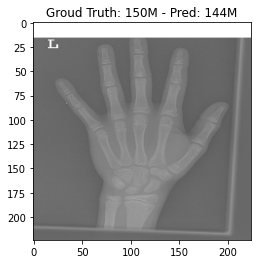

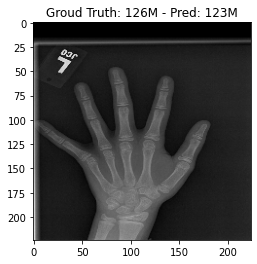

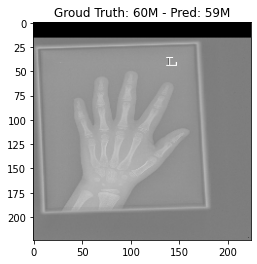

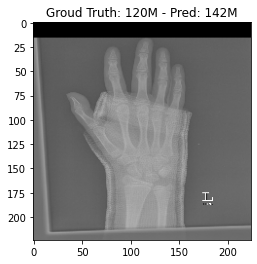

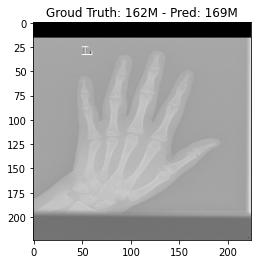

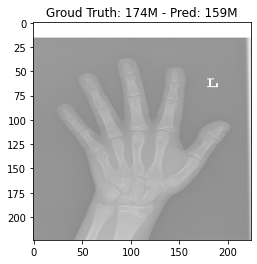

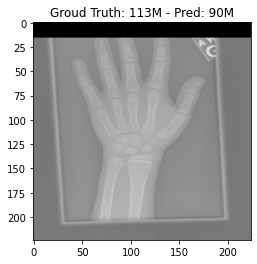

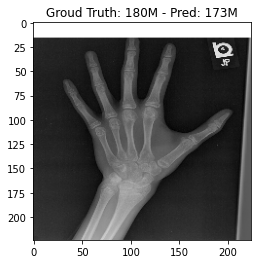

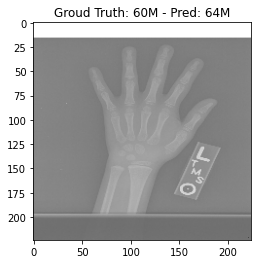

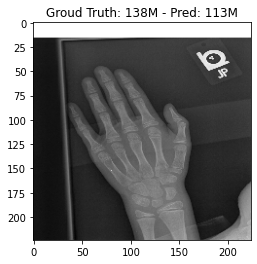

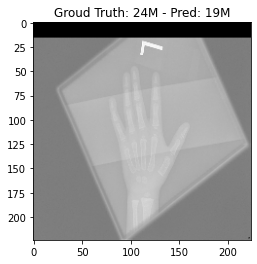

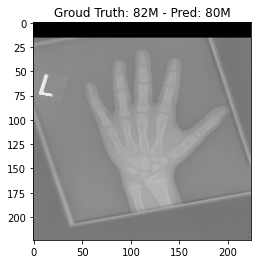

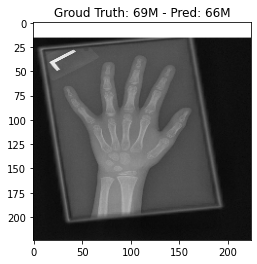

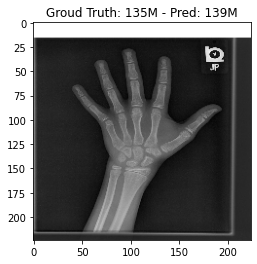

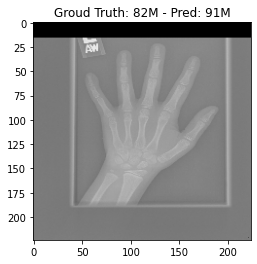

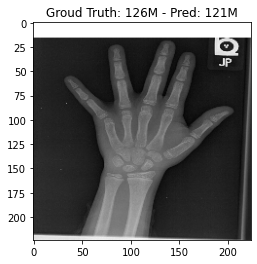

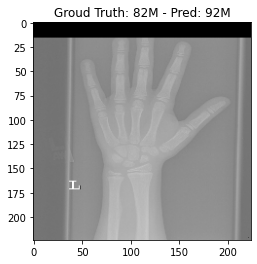

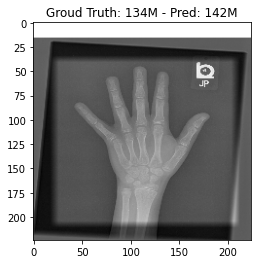

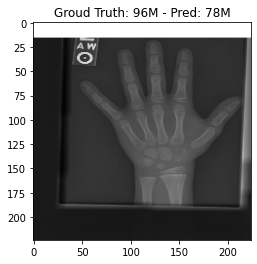

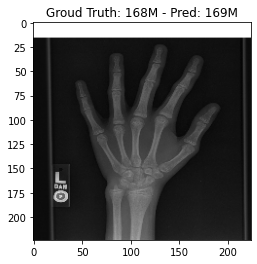

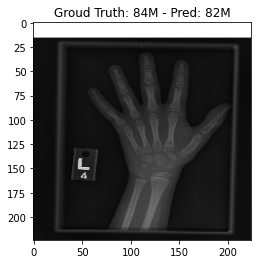

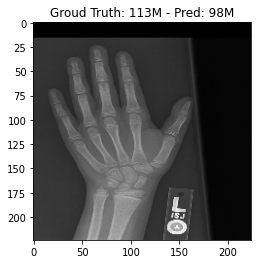

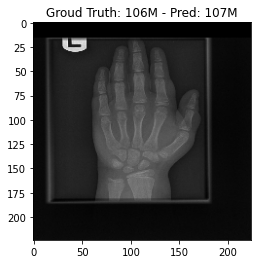

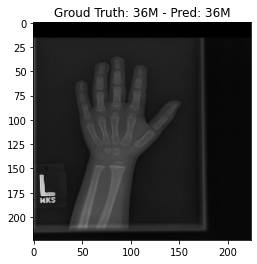

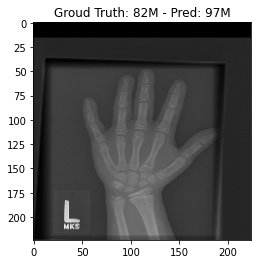

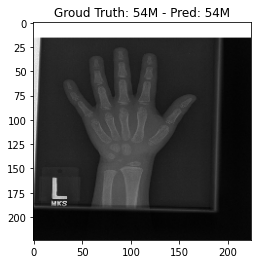

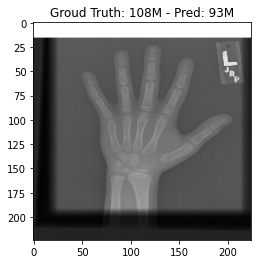

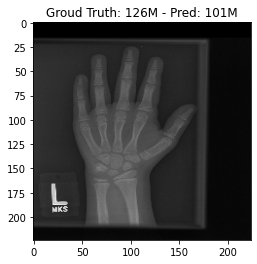

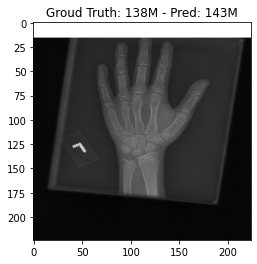

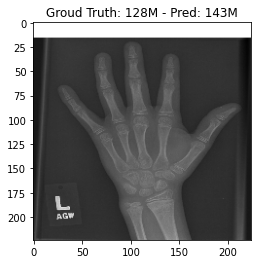

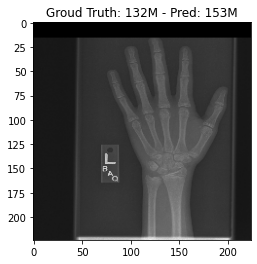

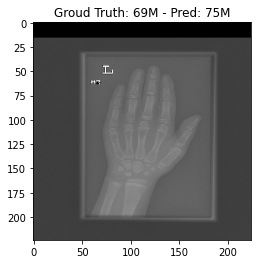

In [ ]:
tk0 = test_loader

for images in tk0:
    for i, image in enumerate(images):
        plt.figure()
        plt.imshow(torch.movedim(image, -3, 2))
        plt.title('Groud Truth: ' + str(round(test_labels[i] * 200)) + 'M - Pred: ' + str(round(preds[i][0] * 200.)) + 'M')
        plt.show()
    break

It's a wrap. We have trained a regression model to predict bone age from hand/wrist x-rays.